## preparar la base de datos

In [1]:
# código funciona perfectamente
import os
import csv

def cargar_lineas_validas(csv_path, salto=34):
    lineas = []
    with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if i >= salto:
                if line.strip() == "":
                    break
                lineas.append(line.strip())
    return lineas

def encontrar_ruta_componente(archivo, dirs_prioridad):
    for d in dirs_prioridad:
        posible = os.path.join(d, archivo)
        if os.path.exists(posible):
            return posible
    return None

def procesar_vs30(tipo, magnitud, vs30, vs30_path, registros_validos):
    componentes = {
        "H1": os.path.join(vs30_path, "Componente Horizontal 1"),
        "H2": os.path.join(vs30_path, "Componente Horizontal 2"),
        "V":  os.path.join(vs30_path, "Componente Vertical")
    }
    search_csv = os.path.join(vs30_path, "_SearchResults.csv")
    if not os.path.isfile(search_csv):
        print(f"⚠️ No se encuentra el archivo CSV: {search_csv}")
        return 0

    lineas = cargar_lineas_validas(search_csv)
    if not lineas:
        print(f"⚠️ No se encontraron líneas válidas en el CSV: {search_csv}")
        return 0

    validos = 0
    for linea in lineas:
        row = linea.split(",")
        if len(row) < 3:
            continue
        arch_h1, arch_h2, arch_v = row[-3].strip(), row[-2].strip(), row[-1].strip()
        ruta_h1 = encontrar_ruta_componente(arch_h1, [componentes["H1"], componentes["H2"], componentes["V"]])
        ruta_h2 = encontrar_ruta_componente(arch_h2, [componentes["H2"], componentes["H1"]])
        ruta_v  = encontrar_ruta_componente(arch_v,  [componentes["V"],  componentes["H1"], componentes["H2"]])
        
        if ruta_h1 and ruta_h2 and ruta_v:
            validos += 1
            registros_validos.append({
                "Tipo de evento": tipo,
                "Magnitud": magnitud,
                "Vs30": vs30,
                "Archivo H1": arch_h1,
                "Ruta H1": ruta_h1,
                "Archivo H2": arch_h2,
                "Ruta H2": ruta_h2,
                "Archivo V": arch_v,
                "Ruta V": ruta_v
            })
        else:
            print("❌ Faltan archivos:", end=" ")
            if not ruta_h1: print("H1", end=" ")
            if not ruta_h2: print("H2", end=" ")
            if not ruta_v:  print("V",  end=" ")
            print(f"→ en {vs30_path}")
    return validos

def contar_eventos_validos_y_guardar_csv(base_path, tipos_evento, archivo_salida="eventos_validos.csv"):
    total_global = 0
    registros_validos = []

    for tipo in tipos_evento:
        tipo_path = os.path.join(base_path, tipo)
        if not os.path.isdir(tipo_path):
            print(f"❌ No existe la carpeta de tipo: {tipo_path}")
            continue

        for magnitud in os.listdir(tipo_path):
            mag_path = os.path.join(tipo_path, magnitud)
            if not os.path.isdir(mag_path):
                continue

            for vs30 in os.listdir(mag_path):
                vs30_path = os.path.join(mag_path, vs30)
                if not os.path.isdir(vs30_path):
                    continue

                total_local = procesar_vs30(tipo, magnitud, vs30, vs30_path, registros_validos)
                total_global += total_local

                estado = "✅" if total_local > 0 else "⚠️"
                print(f"📁 {tipo} | {magnitud} | {vs30} → {estado} {total_local} eventos válidos")

    # Guardar CSV
    if registros_validos:
        campos = list(registros_validos[0].keys())
        with open(archivo_salida, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=campos)
            writer.writeheader()
            writer.writerows(registros_validos)
        print(f"\n📄 Archivo CSV generado: {archivo_salida}")
    else:
        print("\n⚠️ No se generó ningún registro válido, no se creó el CSV.")

    return total_global

# Ejecutar
base_dir = os.path.join(os.getcwd(), "Base-sismos-2024")
tipos = ["1 Stiker Slip (SS)", "2 Normal-Oblique", "3 Reverse-Oblique"]
total = contar_eventos_validos_y_guardar_csv(base_dir, tipos)
print("\n🎯 TOTAL GLOBAL de eventos válidos con los tres componentes:", total)


❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 200-400 → ✅ 97 eventos válidos
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 400-600
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 400-600
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 400-600 → ✅ 98 eventos válidos
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 0-200 → ✅ 40 eventos válidos
❌ Faltan 

In [2]:
import pandas as pd

In [3]:
df_completo = pd.read_csv('eventos_validos.csv', encoding='utf-8')

In [4]:
# Creación del ID
import pandas as pd
import numpy as np
ph1=df_completo['Archivo H1'].str.split('_').str[:2].str.join('_')
ph2=df_completo['Archivo H2'].str.split('_').str[:2].str.join('_')
phv=df_completo['Archivo V'].str.split('_').str[:2].str.join('_')

mascara = (ph1 == ph2) & (ph1 == phv)
df_completo.loc[mascara, 'Evento ID'] = ph1[mascara]
columnas = ['Evento ID']+ [c for c in df_completo.columns if c != 'Evento ID']
df_completo = df_completo[columnas] #Reordenar, luego esto se lo meteria en el codigo de Andres para que eeste mas clean

#Nose como funciono esto, pero chat ayudo
ocurrencias = df_completo.groupby('Evento ID').cumcount()
mask_segundas = ocurrencias == 1

# 3) Renombra sólo esas filas, añadiendo "_2" al final
df_completo.loc[mask_segundas, 'Evento ID'] = (
    df_completo.loc[mask_segundas, 'Evento ID'] + '_2'
)

df_completo['Evento ID'].nunique()
df_completo.to_csv('eventos_actualizado.csv', index=False) #OJO A LOS NOMBRES DE ARCHIVO


In [5]:
df_completo

,Evento ID,Tipo de evento,Magnitud,Vs30,Archivo H1,Ruta H1,Archivo H2,Ruta H2,Archivo V,Ruta V
0,RSN3_HUMBOLT,1 Stiker Slip (SS),Mag. 4-6,Vs30. 200-400,RSN3_HUMBOLT_FRN225.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN3_HUMBOLT_FRN315.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN3_HUMBOLT_FRN-UP.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
1,RSN4_IMPVALL.BG,1 Stiker Slip (SS),Mag. 4-6,Vs30. 200-400,RSN4_IMPVALL.BG_B-ELC000.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN4_IMPVALL.BG_B-ELC090.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN4_IMPVALL.BG_B-ELC-UP.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
2,RSN5_NWCALIF.AB,1 Stiker Slip (SS),Mag. 4-6,Vs30. 200-400,RSN5_NWCALIF.AB_A-FRN045.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN5_NWCALIF.AB_A-FRN135.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN5_NWCALIF.AB_A-FRNDWN.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
3,RSN10_IMPVALL.BG,1 Stiker Slip (SS),Mag. 4-6,Vs30. 200-400,RSN10_IMPVALL.BG_C-ELC000.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN10_IMPVALL.BG_C-ELC090.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN10_IMPVALL.BG_C-ELC-UP.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
4,RSN11_NWCALIF.AB,1 Stiker Slip (SS),Mag. 4-6,Vs30. 200-400,RSN11_NWCALIF.AB_B-FRN224.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN11_NWCALIF.AB_B-FRN314.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN11_NWCALIF.AB_B-FRN-UP.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
...,...,...,...,...,...,...,...,...,...,...
1691,RSN1577_CHICHI,3 Reverse-Oblique,Mag. 6-8,Vs30. 600-,RSN1577_CHICHI_TTN025-E.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1577_CHICHI_TTN025-N.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1577_CHICHI_TTN025-V.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
1692,RSN1580_CHICHI,3 Reverse-Oblique,Mag. 6-8,Vs30. 600-,RSN1580_CHICHI_TTN028-E.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1580_CHICHI_TTN028-N.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1580_CHICHI_TTN028-V.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
1693,RSN1582_CHICHI,3 Reverse-Oblique,Mag. 6-8,Vs30. 600-,RSN1582_CHICHI_TTN032-E.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1582_CHICHI_TTN032-N.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1582_CHICHI_TTN032-V.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...
1694,RSN1583_CHICHI,3 Reverse-Oblique,Mag. 6-8,Vs30. 600-,RSN1583_CHICHI_TTN033-E.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1583_CHICHI_TTN033-N.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...,RSN1583_CHICHI_TTN033-V.AT2,/Users/benjaminvaca/Documents/USFQ/semestre7/m...


In [6]:
# Creo que tiene ya todo junto
import re

def processNGAfile3(filepath, scalefactor=None):
    """
    Lee un .AT2 y devuelve (npts, dt, time, inp_acc), buscando dinámicamente
    la línea con NPTS= y DT=, y detectando el inicio de los datos numéricos.
    """
    if scalefactor is None:
        scalefactor = 1.0

    with open(filepath, 'r') as f:
        lines = f.readlines()

    # 1) Buscar NPTS y DT en las primeras 20 líneas
    npts = dt = None
    for line in lines[:20]:
        m_n = re.search(r'NPTS\s*=\s*([0-9]+)', line)
        m_d = re.search(r'DT\s*=\s*([0-9]*\.?[0-9]+)', line)
        if m_n: npts = int(m_n.group(1))
        if m_d: dt   = float(m_d.group(1))
        if npts is not None and dt is not None:
            break
    if npts is None or dt is None:
        raise ValueError(f"No se encontró NPTS/DT en {filepath}")

    # 2) Detectar el índice donde empiezan los datos (línea con floats)
    start_idx = None
    num_pattern = re.compile(r'^[-+]?[0-9]*\.?[0-9]+')
    for i, line in enumerate(lines):
        tokens = line.strip().split()
        # si TODOS los tokens tienen formato numérico, asumimos datos
        if tokens and all(num_pattern.match(t) for t in tokens):
            start_idx = i
            break
    if start_idx is None:
        raise ValueError(f"No se encontró inicio de datos en {filepath}")

    # 3) Leer todos los valores desde start_idx en adelante
    acc_data = []
    for line in lines[start_idx:]:
        for tok in line.strip().split():
            acc_data.append(float(tok) * scalefactor)

    inp_acc = np.array(acc_data, dtype=float)
    time    = np.arange(len(acc_data)) * dt

    return npts, dt, time, inp_acc


In [7]:
#Verificacion de que se estan leyendo bien los datos que nos interesan para hacer la normalizacion
import pandas as pd

def agregar_dt_npts(df, comp_cols=('Ruta H1','Ruta H2','Ruta V')):
    """
    A un DataFrame que ya contiene rutas completas en comp_cols,
    le añade dos columnas por componente: NPTS_<sufijo> y DT_<sufijo>.

    Parámetros
    ----------
    df : pd.DataFrame
        Debe tener al menos las columnas indicadas en comp_cols, con la ruta
        completa al archivo .AT2 en cada celda.
    comp_cols : tuple de str
        Nombres de las columnas de df con las rutas para H1, H2 y V.

    Devuelve
    -------
    pd.DataFrame
        Copia de df con las 6 columnas adicionales.
    """
    df2 = df.copy()

    for comp in comp_cols:
        npts_list = []
        dt_list   = []

        # Procesa cada ruta de archivo directamente
        for filepath in df2[comp]:
            # Llama a tu parser robusto:
            npts, dt,_,_ = processNGAfile3(filepath)
            npts_list.append(int(npts))
            dt_list.append(float(dt))

        # Extrae sufijo 'H1','H2' o 'V' a partir del nombre de la columna
        suf = comp.split()[-1]

        # Añade las nuevas columnas
        df2[f'NPTS_{suf}'] = npts_list
        df2[f'DT_{suf}']   = dt_list

    return df2


In [8]:
df_completo=agregar_dt_npts(df_completo,comp_cols=('Ruta H1','Ruta H2','Ruta V'))

In [9]:

# Lista con todos los nuevos nombres, en el orden actual de las columnas
df_completo.columns = ['Evento ID', 'Tipo de evento', 'Magnitud', 'Vs30',
              'Archivo H2', 'Ruta H2', 'Archivo H1', 'Ruta H1',
              'Archivo V', 'Ruta V', 'NPTS_H2', 'DT_H2', 'NPTS_H1', 'DT_H1', 'NPTS_HV', 'DT_HV']

In [10]:
import numpy as np
from scipy.interpolate import interp1d

def normalizar_frecuencia_muestreo(tiempo, aceleracion, dt_obj=0.01):
    t0, t1 = tiempo[0], tiempo[-1]
    t_new   = np.arange(t0, t1, dt_obj)
    f       = interp1d(tiempo, aceleracion,
                       kind='linear',
                       fill_value='extrapolate')
    acc_new = f(t_new)
    return t_new, acc_new

In [11]:

def estandarización(df, comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                          parser=processNGAfile3,
                          dt_obj=0.01):

    for label in ['H1','H2','V']:
        df[f'Acc_{label}_std'] = None
    df['NPTS_common'] = None
    df['DT_common']   = None

    # 2) Recorre cada evento (fila) de df
    for idx, row in df.iterrows():
        remuestreos = {}

        # 2a) Leer y remuestrear
        for label, col in zip(['H1','H2','V'], comp_cols):
            npts, dt, tiempo, acc = parser(row[col])
            # avisar si el dt original no es el esperado
            if abs(dt - dt_obj) > 1e-8:
                print(f"[Aviso] dt original {dt}≠{dt_obj} en fila {idx} / {label}")
            # remuestreo
            _, acc_norm = normalizar_frecuencia_muestreo(tiempo, acc, dt_obj=dt_obj)
            remuestreos[label] = acc_norm

        # 2b) Determinar longitud mínima común
        min_len = min(len(a) for a in remuestreos.values())
        df.at[idx, 'NPTS_common'] = min_len
        df.at[idx, 'DT_common']   = dt_obj

        # 2c) Truncar y guardar en df
        for label in ['H1','H2','V']:
            df.at[idx, f'Acc_{label}_std'] = remuestreos[label][:min_len].tolist()

    return df

In [12]:
df_completo = estandarización(df_completo,
                                           comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                                           parser=processNGAfile3,dt_obj=0.01)



[Aviso] dt original 0.005≠0.01 en fila 0 / H1
[Aviso] dt original 0.005≠0.01 en fila 0 / H2
[Aviso] dt original 0.005≠0.01 en fila 0 / V
[Aviso] dt original 0.005≠0.01 en fila 1 / H1
[Aviso] dt original 0.005≠0.01 en fila 1 / H2
[Aviso] dt original 0.005≠0.01 en fila 1 / V
[Aviso] dt original 0.005≠0.01 en fila 2 / H1
[Aviso] dt original 0.005≠0.01 en fila 2 / H2
[Aviso] dt original 0.005≠0.01 en fila 2 / V
[Aviso] dt original 0.005≠0.01 en fila 3 / H1
[Aviso] dt original 0.005≠0.01 en fila 3 / H2
[Aviso] dt original 0.005≠0.01 en fila 3 / V
[Aviso] dt original 0.005≠0.01 en fila 4 / H1
[Aviso] dt original 0.005≠0.01 en fila 4 / H2
[Aviso] dt original 0.005≠0.01 en fila 4 / V
[Aviso] dt original 0.005≠0.01 en fila 5 / H1
[Aviso] dt original 0.005≠0.01 en fila 5 / H2
[Aviso] dt original 0.005≠0.01 en fila 5 / V
[Aviso] dt original 0.005≠0.01 en fila 6 / H1
[Aviso] dt original 0.005≠0.01 en fila 6 / H2
[Aviso] dt original 0.005≠0.01 en fila 6 / V
[Aviso] dt original 0.005≠0.01 en fila 7 

In [13]:
def FFT_featuring(aceleracion): 

    FFT = np.fft.rfft(aceleracion, n=512) 
    magnitud = np.abs(FFT)

    return magnitud

In [14]:
import ast
df_completo['mag_H1'] = df_completo['Acc_H1_std'].apply(lambda x: FFT_featuring(x))
df_completo['mag_H2'] = df_completo['Acc_H2_std'].apply(lambda x: FFT_featuring(x))
df_completo['mag_V']  = df_completo['Acc_V_std'].apply(lambda x: FFT_featuring(x))

# 3. Concatenar las tres magnitudes en una columna de 'features'
df_completo['features_sep'] = df_completo.apply(
    lambda r: np.concatenate([r['mag_H1'], r['mag_H2'], r['mag_V']]),
    axis=1
)

#Mientras respetes la consistencia de segmentos, no “se mezclan” físicamente las componentes: H1 nunca aparece donde va H2, porque tus índices delimitarán qué parte del vector pertenece a cada canal. Entender mejor , tal vez sea importante guardar ese orden?

In [15]:
df_pre = df_completo.copy()
df_pre.drop(columns=[ 'Archivo H2',
       'Ruta H2', 'Archivo H1', 'Ruta H1', 'Archivo V', 'Ruta V', 'NPTS_H2',
       'DT_H2', 'NPTS_H1', 'DT_H1', 'NPTS_HV', 'DT_HV', 'Acc_H1_std',
       'Acc_H2_std', 'Acc_V_std', 'NPTS_common', 'DT_common'], inplace=True)

In [16]:
pip install iterative-stratification



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import OneHotEncoder

In [18]:
# Separar la data
#X_separado = df_precopy[['mag_H1','mag_H2','mag_V']]

X = np.vstack(df_pre['features_sep'].values)  # shape (n_samples, n_feats) #algo esta mal con esto podemos probar despues
y_raw = df_pre[['Tipo de evento','Magnitud','Vs30']]


mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
train_idx, test_idx = next(mskf.split(X, y_raw))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_raw.iloc[train_idx], y_raw.iloc[test_idx]

print(f"Training set: {X_train.shape[0]} muestras") 
print(f"Testing set: {X_test.shape[0]} muestras")

Training set: 1357 muestras
Testing set: 339 muestras


In [19]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

encoder = OneHotEncoder(sparse_output=False) 

y_trainOHE = encoder.fit_transform(y_train)
y_testOHE = encoder.transform(y_test)


## RED NEURONAL

In [20]:
!pip install lightning
!pip install torchmetrics


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [21]:
import lightning as L
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import numpy as np

class NumpyMultilabelDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            # tu pipeline: numpy → FloatTensor
            x = self.transform(x)
        # para BCEWithLogitsLoss necesitamos float en y
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

class DataModule(L.LightningDataModule):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size = 64): #De la documentación
        super().__init__()
        # Particiones
        self.X_train = X_train
        self.y_train = y_train
        self.X_val =  X_val   
        self.y_val= y_val
        self.X_test  = X_test
        self.y_test =y_test
        self.batch_size = batch_size

        # pipeline de transform: numpy 1D → FloatTensor
        self.transform = T.Compose([
            T.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
            # si quisieras centrar/escalar por característica:
            # T.Normalize(mean=[...], std=[...])
        ])

        # metadata para tu modelo
        self.input_shape = X_train.shape[1]
        self.num_classes = y_train.shape[1]

        # placeholders
        self.train_dataset   = None
        self.val_dataset     = None
        self.test_dataset    = None
        self.predict_dataset = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # solo creamos los datasets con lo que ya tienes
        if stage == "fit" or stage is None:
            self.train_dataset = NumpyMultilabelDataset(self.X_train, self.y_train, transform=self.transform)
            self.val_dataset = NumpyMultilabelDataset(self.X_val, self.y_val, transform=self.transform)

        if stage == "test" or stage is None:
            self.test_dataset = NumpyMultilabelDataset(self.X_test, self.y_test, transform=self.transform)

        if stage == "predict" or stage is None:
            # por ejemplo, solo los 5 primeros para demo
            full_test = NumpyMultilabelDataset(self.X_test, self.y_test, transform=self.transform)
            self.predict_dataset = Subset(full_test, range(5))

    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset,batch_size=self.batch_size,shuffle=False)


In [22]:
!pip install torch-optimizer


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import RepeatedKFold
import numpy as np
from torchmetrics.classification import MultilabelF1Score
import pandas as pd
from torch_optimizer import RAdam
from torchmetrics.classification import MultilabelHammingDistance
from torchmetrics.classification import MultilabelAUROC, MultilabelPrecisionRecallCurve
from torchmetrics.classification import (
    MultilabelPrecision,
    MultilabelRecall
)


class Mymodel2(L.LightningModule):
    def __init__(self, input_shape, num_classes, hidden_units, lambda_L2=0.0):
        super().__init__()
        self.hidden_units = hidden_units  # Store the list of hidden units
        layers = []

        for units in hidden_units: #hidden layers
            layers.append(nn.Linear(input_shape, units))
            layers.append(nn.BatchNorm1d(units))
            layers.append(nn.LeakyReLU(negative_slope=0.01)) #Activcion
            layers.append(nn.Dropout(0.3))
            input_shape = units
        layers.append(nn.Linear(input_shape, num_classes))#output layer, logits 9
        self.classifier = nn.Sequential(*layers) #clasificador

        self.lambda_L2 = lambda_L2  # L2 regularization strength
        self.loss = nn.BCEWithLogitsLoss() #Loss function para problemas multilabel

        self.hamming = MultilabelHammingDistance(num_labels=num_classes)
        self.f1_macro = MultilabelF1Score(num_labels=num_classes, average='macro')
    #for inference
    def forward(self, x):
        return self.classifier(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=self.lambda_L2)

    #Que deberia de aumentar en el codigo para poder cumplir con BCEWithLogitsLoss()
    def shared_step(self, batch):
        x, y = batch              # y debe ser un tensor float32 de shape [B, C]
        logits = self(x)          # [B, C]
        loss   = self.loss(logits, y)

        # convertir logits → probabilidades → predicciones binarias
        probs = torch.sigmoid(logits)            # [B, C], en [0,1]
        preds = (probs > 0.5).int()              # umbral 0.5 → {0,1}

        return loss, probs,preds, y
    
    def training_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('train_loss', loss, logger=True,prog_bar=True)
        self.log('train_ham', ham,  logger=True,prog_bar=True)
        self.log('train_f1ma', f1ma, logger=True,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('val_ham', ham, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('val_f1ma', f1ma, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('test_loss', loss, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('test_ham', ham, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('test_f1ma', f1ma, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        return loss
    
    def predict_step(self, batch): #not necessary if dataloader with custom collate for prediction available (see OPTION 3 at the end of the notebook)
        # this calls forward for the inputs only
        inputs, labels = batch
        return self(inputs) #return logits, this calls forward


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Comando para indicar que queremos usar GPU
print("You are using", device)
!nvidia-smi #Comando para obtener datos de GPU
!nvidia-smi -L
num_gpus = 1
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(x) for x in range(num_gpus))
print("CUDA_VISIBLE_DEVICES =", os.environ["CUDA_VISIBLE_DEVICES"])

You are using cpu
zsh:1: command not found: nvidia-smi
zsh:1: command not found: nvidia-smi
CUDA_VISIBLE_DEVICES = 0


In [25]:
from sklearn.model_selection import RepeatedKFold
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pytorch_lightning as L
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def ValidacionCruzada(
    hidden_units,
    Xtrain,
    ytrain,
    Xtest,
    ytest,
    batch_size = 32,
    n_splits = 5,
    n_repeats = 2,
    max_epochs = 50,
    lambda_L2 = 0.0,
):
    """
    Repeated K-Fold CV para multilabel, registrando todas las métricas.
    """

    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    # inicializar listas para cada métrica
    # listas por métrica
    losses      = []
    hamming     = []
    f1_macro    = []
    train_f1mas = []
    val_f1mas   = []
    test_f1mas  = []

    total_folds = n_splits * n_repeats
    for fold, (train_idx, val_idx) in enumerate(rkf.split(Xtrain), start=1):
        print(f"Fold {fold}/{total_folds}")

        X_tr, X_val = Xtrain[train_idx], Xtrain[val_idx]
        y_tr, y_val = ytrain[train_idx], ytrain[val_idx]

        dm = DataModule(
            X_train=X_tr, y_train=y_tr,
            X_val=  X_val, y_val=  y_val,
            X_test= Xtest, y_test=ytest,
            batch_size=batch_size
        )
        dm.prepare_data(); dm.setup()

        early_stop = EarlyStopping(
            monitor='val_f1ma', mode='max', patience=3
        )
        ckpt = ModelCheckpoint(
            monitor='val_f1ma', mode='max',
            save_top_k=5, save_last=True
        )

        model = Mymodel2(
            input_shape=dm.input_shape,
            num_classes=dm.num_classes,
            hidden_units=hidden_units,
            lambda_L2=lambda_L2
        )

        trainer = L.Trainer(
            max_epochs=max_epochs,
            callbacks=[early_stop, ckpt],
            accelerator="gpu" if (device and device.type=="cuda") else "cpu",
            devices=1,
            logger=False
        )

        trainer.fit(
            model,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=  dm.val_dataloader()
        )
         # 2) extraer F1-macro en TRAIN con el mejor ckpt
        train_res = trainer.validate(
            model,
            dataloaders=dm.train_dataloader(),
            ckpt_path='best',
            verbose=False
        )[0]
        train_f1mas.append(train_res['val_f1ma_epoch'])

        # 3) extraer F1-macro en VAL con el mismo ckpt
        val_res = trainer.validate(
            model,
            dataloaders=dm.val_dataloader(),
            ckpt_path='best',
            verbose=False
        )[0]
        val_f1mas.append(val_res['val_f1ma_epoch'])
        res = trainer.test(
            model,
            dataloaders=dm.test_dataloader(),
            ckpt_path='best'
        )

        # extraer métricas *_epoch
        losses.append(    res[0]['test_loss_epoch']   )
        hamming.append(   res[0]['test_ham_epoch']    )
        f1_macro.append(  res[0]['test_f1ma_epoch']   )


        print(
            f"  loss: {losses[-1]:.4f} | hamming: {hamming[-1]:.4f} | "
            f"f1_macro: {f1_macro[-1]:.4f}"
        )

    # calcular medias y desviaciones
    def mean_std(lst):
        return np.mean(lst), np.std(lst)

    avg_loss, std_loss           = mean_std(losses)
    avg_ham,  std_ham            = mean_std(hamming)
    avg_f1ma, std_f1ma           = mean_std(f1_macro)


    print(f"\nF1-macro promedio: {avg_f1ma:.4f} ± {std_f1ma:.4f}")
    print(f"Hamming promedio: {avg_ham:.4f} ± {std_ham:.4f}")
    print(f"Pérdida promedio:         {avg_loss:.4f} ± {std_loss:.4f}")

    return {
        # métricas por fold
        'train_f1ma': train_f1mas,
        'val_f1ma':   val_f1mas,
        'test_f1ma':  test_f1mas,
        'losses':     losses,
        'hamming':    hamming,
        'f1_macro':   f1_macro,

        # y si quieres las medias/desv:
        'avg_loss':       avg_loss,
        'std_loss':       std_loss,
        'avg_hamming':    avg_ham,
        'std_hamming':    std_ham,
        'avg_f1_macro':   avg_f1ma,
        'std_f1_macro':   std_f1ma,
    }

In [26]:
from itertools import product

hidden_layers_options = [
    [512,256,128],
    [256,128,64],
    [256,256,256]
]
lambda_L2_options = [1e-2, 1e-3, 1e-4]

param_grid = [
    {'hidden_units': hu, 'lambda_L2': l2}
    for hu, l2 in product(hidden_layers_options, lambda_L2_options)
]


In [27]:
best_score = -float('inf')
best_params = None

grid_results = {} 
for p in param_grid:
    # devuelvo sólo la media de val_f1ma:
    mean_val_f1 = ValidacionCruzada(
        hidden_units = p['hidden_units'],
        Xtrain       = X_train,
        ytrain       = y_trainOHE,
        Xtest        = X_test,
        ytest        = y_testOHE,
        batch_size   = 32,
        n_splits     = 5,
        n_repeats    = 2,
        max_epochs   = 50,
        lambda_L2    = p['lambda_L2'],
    )['avg_f1_macro']

    arch_str = "-".join(map(str, p['hidden_units']))
    grid_results[(arch_str, p['lambda_L2'])] = mean_val_f1
    print(f"HU={p['hidden_units']}  L2={p['lambda_L2']} → val_f1ma: {mean_val_f1:.4f}")
    if mean_val_f1 > best_score:
        best_score = mean_val_f1
        best_params = p

print("🏆 Mejor configuración:", best_params, "→ val_f1ma:", best_score)


Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints exists and is not empty.

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562

/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('val_ham', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('val_f1ma', ..., logger=True)` but

Epoch 0: 100%|██████████| 34/34 [00:00<00:00, 219.58it/s, train_loss=0.597, train_ham=0.318, train_f1ma=0.270]

/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('train_ham', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('train_f1ma', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 174.84it/s, train_loss=0.536, train_ham=0.272, train_f1ma=0.313, val_loss_step=0.547, val_ham_step=0.375, val_f1ma_step=0.0691, val_loss_epoch=0.567, val_ham_epoch=0.288, val_f1ma_epoch=0.162]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v125.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v125.ckpt
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 505.27it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v125.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v125.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 518.88it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v125.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v125.ckpt
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 502.33it/s]


/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_ham', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_f1ma', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22737623751163483    │
│      test_ham_epoch       │    0.32317274808883667    │
│      test_loss_epoch      │    0.6165357828140259     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6165 | hamming: 0.3232 | f1_macro: 0.2274
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 176.91it/s, train_loss=0.550, train_ham=0.291, train_f1ma=0.279, val_loss_step=0.602, val_ham_step=0.431, val_f1ma_step=0.0261, val_loss_epoch=0.575, val_ham_epoch=0.303, val_f1ma_epoch=0.128]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v126.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v126.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 513.74it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v126.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v126.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 511.92it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v126.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v126.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 510.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2034314125776291     │
│      test_ham_epoch       │    0.30776795744895935    │
│      test_loss_epoch      │    0.6068399548530579     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6068 | hamming: 0.3078 | f1_macro: 0.2034
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 174.82it/s, train_loss=0.593, train_ham=0.315, train_f1ma=0.282, val_loss_step=0.564, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.575, val_ham_epoch=0.300, val_f1ma_epoch=0.156]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v130.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v130.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 525.88it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v130.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v130.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 526.97it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v130.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v130.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 467.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.13960351049900055    │
│      test_ham_epoch       │    0.2903965711593628     │
│      test_loss_epoch      │    0.5855068564414978     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5855 | hamming: 0.2904 | f1_macro: 0.1396
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 173.18it/s, train_loss=0.528, train_ham=0.259, train_f1ma=0.357, val_loss_step=0.588, val_ham_step=0.244, val_f1ma_step=0.129, val_loss_epoch=0.578, val_ham_epoch=0.303, val_f1ma_epoch=0.134] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v131.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v131.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 506.32it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v131.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v131.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 518.31it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v131.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v131.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 506.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16043490171432495    │
│      test_ham_epoch       │    0.2897410988807678     │
│      test_loss_epoch      │    0.5812301635742188     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5812 | hamming: 0.2897 | f1_macro: 0.1604
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 177.79it/s, train_loss=0.616, train_ham=0.330, train_f1ma=0.201, val_loss_step=0.550, val_ham_step=0.370, val_f1ma_step=0.0694, val_loss_epoch=0.573, val_ham_epoch=0.288, val_f1ma_epoch=0.156]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v129.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v129.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 501.32it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v129.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v129.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 407.72it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v129.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v129.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 504.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17979975044727325    │
│      test_ham_epoch       │    0.3126843571662903     │
│      test_loss_epoch      │    0.6097003221511841     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6097 | hamming: 0.3127 | f1_macro: 0.1798
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 179.31it/s, train_loss=0.528, train_ham=0.257, train_f1ma=0.346, val_loss_step=0.579, val_ham_step=0.326, val_f1ma_step=0.112, val_loss_epoch=0.570, val_ham_epoch=0.299, val_f1ma_epoch=0.139] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v145.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v145.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 550.17it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v145.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v145.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 536.74it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v145.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v145.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 534.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.14606596529483795    │
│      test_ham_epoch       │    0.29760730266571045    │
│      test_loss_epoch      │    0.5755887031555176     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5756 | hamming: 0.2976 | f1_macro: 0.1461
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 155.08it/s, train_loss=0.580, train_ham=0.318, train_f1ma=0.252, val_loss_step=0.545, val_ham_step=0.382, val_f1ma_step=0.0482, val_loss_epoch=0.574, val_ham_epoch=0.297, val_f1ma_epoch=0.140]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v131.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v131.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 522.01it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v131.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v131.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 552.05it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v131.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v131.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 540.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17878711223602295    │
│      test_ham_epoch       │    0.31956735253334045    │
│      test_loss_epoch      │    0.6117668747901917     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6118 | hamming: 0.3196 | f1_macro: 0.1788
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 173.20it/s, train_loss=0.578, train_ham=0.330, train_f1ma=0.188, val_loss_step=0.599, val_ham_step=0.378, val_f1ma_step=0.0741, val_loss_epoch=0.567, val_ham_epoch=0.285, val_f1ma_epoch=0.164]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v132.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v132.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 539.57it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v132.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v132.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 539.76it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v132.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v132.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 543.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19008633494377136    │
│      test_ham_epoch       │    0.3035070598125458     │
│      test_loss_epoch      │     0.609442949295044     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6094 | hamming: 0.3035 | f1_macro: 0.1901
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 179.55it/s, train_loss=0.549, train_ham=0.259, train_f1ma=0.327, val_loss_step=0.577, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.573, val_ham_epoch=0.291, val_f1ma_epoch=0.145]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v159.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v159.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 533.21it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v159.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v159.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 537.18it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v159.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v159.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 531.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.13800548017024994    │
│      test_ham_epoch       │    0.3035070300102234     │
│      test_loss_epoch      │     0.578301191329956     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5783 | hamming: 0.3035 | f1_macro: 0.1380
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 178.14it/s, train_loss=0.578, train_ham=0.319, train_f1ma=0.227, val_loss_step=0.571, val_ham_step=0.385, val_f1ma_step=0.0729, val_loss_epoch=0.582, val_ham_epoch=0.300, val_f1ma_epoch=0.141]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v134.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v134.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 476.31it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v134.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v134.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 468.94it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v134.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v134.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 432.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20604321360588074    │
│      test_ham_epoch       │    0.30907899141311646    │
│      test_loss_epoch      │    0.6027377247810364     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6027 | hamming: 0.3091 | f1_macro: 0.2060

F1-macro promedio: 0.1770 ± 0.0290
Hamming promedio: 0.3057 ± 0.0106
Pérdida promedio:         0.5978 ± 0.0149
HU=[512, 256, 128]  L2=0.01 → val_f1ma: 0.1770
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 176.35it/s, train_loss=0.513, train_ham=0.249, train_f1ma=0.324, val_loss_step=0.531, val_ham_step=0.347, val_f1ma_step=0.0957, val_loss_epoch=0.549, val_ham_epoch=0.284, val_f1ma_epoch=0.189]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v58.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v58.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 514.28it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v58.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v58.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 524.11it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v58.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v58.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 530.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16289085149765015    │
│      test_ham_epoch       │    0.2848246395587921     │
│      test_loss_epoch      │    0.5564777851104736     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5565 | hamming: 0.2848 | f1_macro: 0.1629
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 178.40it/s, train_loss=0.578, train_ham=0.330, train_f1ma=0.297, val_loss_step=0.598, val_ham_step=0.389, val_f1ma_step=0.0702, val_loss_epoch=0.558, val_ham_epoch=0.301, val_f1ma_epoch=0.176]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v137.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v137.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 540.96it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v137.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v137.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 547.92it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v137.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v137.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 535.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19447265565395355    │
│      test_ham_epoch       │    0.2966240346431732     │
│      test_loss_epoch      │    0.5738226771354675     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5738 | hamming: 0.2966 | f1_macro: 0.1945
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 175.87it/s, train_loss=0.550, train_ham=0.296, train_f1ma=0.270, val_loss_step=0.552, val_ham_step=0.378, val_f1ma_step=0.0729, val_loss_epoch=0.562, val_ham_epoch=0.298, val_f1ma_epoch=0.169]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v151.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v151.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 406.34it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v151.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v151.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 386.98it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v151.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v151.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 408.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18439726531505585    │
│      test_ham_epoch       │    0.2910521328449249     │
│      test_loss_epoch      │    0.5716410875320435     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5716 | hamming: 0.2911 | f1_macro: 0.1844
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 153.84it/s, train_loss=0.554, train_ham=0.296, train_f1ma=0.264, val_loss_step=0.563, val_ham_step=0.281, val_f1ma_step=0.0969, val_loss_epoch=0.577, val_ham_epoch=0.306, val_f1ma_epoch=0.132]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v137.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v137.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 300.58it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v137.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v137.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 300.03it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v137.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v137.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 427.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18693655729293823    │
│      test_ham_epoch       │    0.31694525480270386    │
│      test_loss_epoch      │    0.6052150726318359     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6052 | hamming: 0.3169 | f1_macro: 0.1869
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 143.56it/s, train_loss=0.554, train_ham=0.289, train_f1ma=0.356, val_loss_step=0.574, val_ham_step=0.356, val_f1ma_step=0.117, val_loss_epoch=0.560, val_ham_epoch=0.287, val_f1ma_epoch=0.196] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v138.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v138.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 385.11it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v138.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v138.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 393.49it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v138.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v138.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 383.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19016286730766296    │
│      test_ham_epoch       │    0.30940672755241394    │
│      test_loss_epoch      │    0.5995388627052307     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5995 | hamming: 0.3094 | f1_macro: 0.1902
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 155.93it/s, train_loss=0.593, train_ham=0.345, train_f1ma=0.213, val_loss_step=0.544, val_ham_step=0.208, val_f1ma_step=0.160, val_loss_epoch=0.565, val_ham_epoch=0.311, val_f1ma_epoch=0.140]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v140.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v140.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 440.68it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v140.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v140.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 432.81it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v140.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v140.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 406.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18305903673171997    │
│      test_ham_epoch       │    0.29236313700675964    │
│      test_loss_epoch      │    0.5755159854888916     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5755 | hamming: 0.2924 | f1_macro: 0.1831
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 154.85it/s, train_loss=0.565, train_ham=0.349, train_f1ma=0.235, val_loss_step=0.536, val_ham_step=0.278, val_f1ma_step=0.0923, val_loss_epoch=0.564, val_ham_epoch=0.299, val_f1ma_epoch=0.150]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v140.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v140.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 480.04it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v140.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v140.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 257.18it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v140.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v140.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 408.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2076605260372162     │
│      test_ham_epoch       │    0.30907899141311646    │
│      test_loss_epoch      │    0.5956231355667114     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5956 | hamming: 0.3091 | f1_macro: 0.2077
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 152.30it/s, train_loss=0.557, train_ham=0.285, train_f1ma=0.308, val_loss_step=0.610, val_ham_step=0.407, val_f1ma_step=0.040, val_loss_epoch=0.558, val_ham_epoch=0.288, val_f1ma_epoch=0.166] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v142.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v142.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 426.06it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v142.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v142.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 381.86it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v142.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v142.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 212.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19001781940460205    │
│      test_ham_epoch       │    0.2969518303871155     │
│      test_loss_epoch      │    0.5744390487670898     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5744 | hamming: 0.2970 | f1_macro: 0.1900
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 138.65it/s, train_loss=0.533, train_ham=0.274, train_f1ma=0.336, val_loss_step=0.519, val_ham_step=0.200, val_f1ma_step=0.148, val_loss_epoch=0.559, val_ham_epoch=0.302, val_f1ma_epoch=0.158] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v169.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v169.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 440.85it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v169.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v169.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 418.97it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v169.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v169.ckpt



Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 413.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1710706651210785     │
│      test_ham_epoch       │    0.3005572259426117     │
│      test_loss_epoch      │    0.5640037059783936     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5640 | hamming: 0.3006 | f1_macro: 0.1711
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 158.43it/s, train_loss=0.529, train_ham=0.270, train_f1ma=0.345, val_loss_step=0.531, val_ham_step=0.319, val_f1ma_step=0.117, val_loss_epoch=0.559, val_ham_epoch=0.285, val_f1ma_epoch=0.193] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v38.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v38.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 444.67it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v38.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v38.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 168.19it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v38.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v38.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 400.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18047724664211273    │
│      test_ham_epoch       │    0.2799082100391388     │
│      test_loss_epoch      │    0.5532425045967102     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5532 | hamming: 0.2799 | f1_macro: 0.1805

F1-macro promedio: 0.1851 ± 0.0117
Hamming promedio: 0.2978 ± 0.0110
Pérdida promedio:         0.5770 ± 0.0169
HU=[512, 256, 128]  L2=0.001 → val_f1ma: 0.1851
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 155.88it/s, train_loss=0.524, train_ham=0.284, train_f1ma=0.377, val_loss_step=0.570, val_ham_step=0.375, val_f1ma_step=0.0795, val_loss_epoch=0.554, val_ham_epoch=0.279, val_f1ma_epoch=0.216]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v27.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v27.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 448.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v27.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v27.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 388.77it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v27.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v27.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 204.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23553131520748138    │
│      test_ham_epoch       │    0.27761390805244446    │
│      test_loss_epoch      │    0.5520851016044617     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5521 | hamming: 0.2776 | f1_macro: 0.2355
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 164.39it/s, train_loss=0.507, train_ham=0.261, train_f1ma=0.407, val_loss_step=0.602, val_ham_step=0.417, val_f1ma_step=0.064, val_loss_epoch=0.556, val_ham_epoch=0.297, val_f1ma_epoch=0.190] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v53.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v53.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 453.40it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v53.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v53.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 396.08it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v53.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v53.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 392.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20042453706264496    │
│      test_ham_epoch       │    0.27794164419174194    │
│      test_loss_epoch      │    0.5451051592826843     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5451 | hamming: 0.2779 | f1_macro: 0.2004
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 137.74it/s, train_loss=0.520, train_ham=0.248, train_f1ma=0.366, val_loss_step=0.551, val_ham_step=0.407, val_f1ma_step=0.0523, val_loss_epoch=0.561, val_ham_epoch=0.298, val_f1ma_epoch=0.202]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v144.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v144.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 380.46it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v144.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v144.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 299.54it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v144.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v144.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 343.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20201894640922546    │
│      test_ham_epoch       │    0.2953130304813385     │
│      test_loss_epoch      │    0.5750812888145447     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5751 | hamming: 0.2953 | f1_macro: 0.2020
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 155.34it/s, train_loss=0.540, train_ham=0.293, train_f1ma=0.355, val_loss_step=0.590, val_ham_step=0.319, val_f1ma_step=0.111, val_loss_epoch=0.557, val_ham_epoch=0.300, val_f1ma_epoch=0.165] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v66.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v66.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 466.07it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v66.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v66.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 466.78it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v66.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v66.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 470.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16768713295459747    │
│      test_ham_epoch       │    0.28154703974723816    │
│      test_loss_epoch      │     0.556938648223877     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5569 | hamming: 0.2815 | f1_macro: 0.1677
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 16: 100%|██████████| 34/34 [00:00<00:00, 179.04it/s, train_loss=0.495, train_ham=0.237, train_f1ma=0.458, val_loss_step=0.519, val_ham_step=0.281, val_f1ma_step=0.153, val_loss_epoch=0.559, val_ham_epoch=0.282, val_f1ma_epoch=0.211]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v7.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v7.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 511.37it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v7.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v7.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 440.72it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v7.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v7.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 412.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2118847817182541     │
│      test_ham_epoch       │    0.28056374192237854    │
│      test_loss_epoch      │    0.5553620457649231     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5554 | hamming: 0.2806 | f1_macro: 0.2119
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 174.65it/s, train_loss=0.511, train_ham=0.268, train_f1ma=0.343, val_loss_step=0.630, val_ham_step=0.354, val_f1ma_step=0.105, val_loss_epoch=0.556, val_ham_epoch=0.291, val_f1ma_epoch=0.175]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v160.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v160.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 506.84it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v160.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v160.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 515.93it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v160.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v160.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 515.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19584554433822632    │
│      test_ham_epoch       │    0.2890855371952057     │
│      test_loss_epoch      │    0.5657505393028259     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5658 | hamming: 0.2891 | f1_macro: 0.1958
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 34/34 [00:00<00:00, 152.76it/s, train_loss=0.497, train_ham=0.264, train_f1ma=0.428, val_loss_step=0.523, val_ham_step=0.354, val_f1ma_step=0.0984, val_loss_epoch=0.567, val_ham_epoch=0.288, val_f1ma_epoch=0.214]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=11-step=408-v8.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=11-step=408-v8.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 483.95it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=11-step=408-v8.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=11-step=408-v8.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 463.41it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=11-step=408-v8.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=11-step=408-v8.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 474.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21279405057430267    │
│      test_ham_epoch       │    0.2782694399356842     │
│      test_loss_epoch      │    0.5487875938415527     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5488 | hamming: 0.2783 | f1_macro: 0.2128
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 156.61it/s, train_loss=0.540, train_ham=0.274, train_f1ma=0.315, val_loss_step=0.599, val_ham_step=0.311, val_f1ma_step=0.150, val_loss_epoch=0.564, val_ham_epoch=0.304, val_f1ma_epoch=0.188] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v145.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v145.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 489.53it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v145.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v145.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 514.32it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v145.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v145.ckpt



Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 472.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20809130370616913    │
│      test_ham_epoch       │    0.3136676549911499     │
│      test_loss_epoch      │    0.6014472246170044     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6014 | hamming: 0.3137 | f1_macro: 0.2081
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 142.48it/s, train_loss=0.533, train_ham=0.259, train_f1ma=0.378, val_loss_step=0.552, val_ham_step=0.311, val_f1ma_step=0.0523, val_loss_epoch=0.556, val_ham_epoch=0.300, val_f1ma_epoch=0.158]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v146.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v146.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 296.62it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v146.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v146.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 409.15it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v146.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v146.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 403.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22762762010097504    │
│      test_ham_epoch       │    0.3074401915073395     │
│      test_loss_epoch      │    0.6033204793930054     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  loss: 0.6033 | hamming: 0.3074 | f1_macro: 0.2276
Fold 10/10



  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 182.18it/s, train_loss=0.570, train_ham=0.293, train_f1ma=0.315, val_loss_step=0.575, val_ham_step=0.385, val_f1ma_step=0.0936, val_loss_epoch=0.564, val_ham_epoch=0.303, val_f1ma_epoch=0.180]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v147.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v147.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 509.07it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v147.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v147.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 500.47it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v147.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v147.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 523.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19346420466899872    │
│      test_ham_epoch       │    0.3044903576374054     │
│      test_loss_epoch      │    0.5965607166290283     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5966 | hamming: 0.3045 | f1_macro: 0.1935

F1-macro promedio: 0.2055 ± 0.0179
Hamming promedio: 0.2906 ± 0.0130
Pérdida promedio:         0.5700 ± 0.0215
HU=[512, 256, 128]  L2=0.0001 → val_f1ma: 0.2055
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 217.78it/s, train_loss=0.586, train_ham=0.280, train_f1ma=0.287, val_loss_step=0.567, val_ham_step=0.410, val_f1ma_step=0.0378, val_loss_epoch=0.574, val_ham_epoch=0.296, val_f1ma_epoch=0.148]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v40.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v40.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 571.67it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v40.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v40.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 569.79it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v40.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v40.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 549.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15643128752708435    │
│      test_ham_epoch       │    0.28711897134780884    │
│      test_loss_epoch      │    0.5687937140464783     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5688 | hamming: 0.2871 | f1_macro: 0.1564
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 210.05it/s, train_loss=0.589, train_ham=0.314, train_f1ma=0.186, val_loss_step=0.613, val_ham_step=0.410, val_f1ma_step=0.0378, val_loss_epoch=0.575, val_ham_epoch=0.303, val_f1ma_epoch=0.144]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v148.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v148.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 565.36it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v148.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v148.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 548.35it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v148.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v148.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 548.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19091880321502686    │
│      test_ham_epoch       │    0.33693867921829224    │
│      test_loss_epoch      │    0.6312829852104187     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6313 | hamming: 0.3369 | f1_macro: 0.1909
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 207.27it/s, train_loss=0.587, train_ham=0.296, train_f1ma=0.211, val_loss_step=0.557, val_ham_step=0.422, val_f1ma_step=0.0278, val_loss_epoch=0.587, val_ham_epoch=0.298, val_f1ma_epoch=0.135]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v149.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v149.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 563.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v149.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v149.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 548.22it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v149.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v149.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 550.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.14253710210323334    │
│      test_ham_epoch       │    0.3333333432674408     │
│      test_loss_epoch      │    0.6397857069969177     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6398 | hamming: 0.3333 | f1_macro: 0.1425
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 206.00it/s, train_loss=0.571, train_ham=0.322, train_f1ma=0.211, val_loss_step=0.598, val_ham_step=0.385, val_f1ma_step=0.0468, val_loss_epoch=0.585, val_ham_epoch=0.308, val_f1ma_epoch=0.127]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v150.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v150.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 580.47it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v150.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v150.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 553.44it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v150.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v150.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 559.28it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2324725091457367     │
│      test_ham_epoch       │    0.3320222795009613     │
│      test_loss_epoch      │    0.6388725638389587     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6389 | hamming: 0.3320 | f1_macro: 0.2325
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 212.46it/s, train_loss=0.592, train_ham=0.319, train_f1ma=0.213, val_loss_step=0.574, val_ham_step=0.378, val_f1ma_step=0.0556, val_loss_epoch=0.578, val_ham_epoch=0.299, val_f1ma_epoch=0.153]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v151.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v151.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 550.95it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v151.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v151.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 522.92it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v151.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v151.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 538.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15343330800533295    │
│      test_ham_epoch       │    0.32186171412467957    │
│      test_loss_epoch      │    0.6398531198501587     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6399 | hamming: 0.3219 | f1_macro: 0.1534
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 213.51it/s, train_loss=0.557, train_ham=0.295, train_f1ma=0.234, val_loss_step=0.600, val_ham_step=0.361, val_f1ma_step=0.0853, val_loss_epoch=0.579, val_ham_epoch=0.305, val_f1ma_epoch=0.146]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v152.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v152.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 571.89it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v152.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v152.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 568.18it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v152.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v152.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 555.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1715984344482422     │
│      test_ham_epoch       │    0.3277614116668701     │
│      test_loss_epoch      │    0.6372252106666565     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6372 | hamming: 0.3278 | f1_macro: 0.1716
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 213.01it/s, train_loss=0.584, train_ham=0.330, train_f1ma=0.174, val_loss_step=0.581, val_ham_step=0.389, val_f1ma_step=0.0444, val_loss_epoch=0.582, val_ham_epoch=0.297, val_f1ma_epoch=0.136]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v153.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v153.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 457.80it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v153.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v153.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 466.15it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v153.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v153.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 229.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18493077158927917    │
│      test_ham_epoch       │    0.3389052748680115     │
│      test_loss_epoch      │    0.6382456421852112     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6382 | hamming: 0.3389 | f1_macro: 0.1849
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 212.61it/s, train_loss=0.587, train_ham=0.322, train_f1ma=0.223, val_loss_step=0.605, val_ham_step=0.407, val_f1ma_step=0.037, val_loss_epoch=0.576, val_ham_epoch=0.295, val_f1ma_epoch=0.137] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v154.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v154.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 570.56it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v154.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v154.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 557.58it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v154.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v154.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 551.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1660538762807846     │
│      test_ham_epoch       │    0.32317274808883667    │
│      test_loss_epoch      │    0.6280943155288696     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6281 | hamming: 0.3232 | f1_macro: 0.1661
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 208.93it/s, train_loss=0.619, train_ham=0.359, train_f1ma=0.142, val_loss_step=0.582, val_ham_step=0.430, val_f1ma_step=0.0139, val_loss_epoch=0.579, val_ham_epoch=0.289, val_f1ma_epoch=0.140]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v155.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v155.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 571.55it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v155.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v155.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 565.19it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v155.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v155.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 253.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20068809390068054    │
│      test_ham_epoch       │    0.34742704033851624    │
│      test_loss_epoch      │    0.6480283737182617     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6480 | hamming: 0.3474 | f1_macro: 0.2007
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 214.23it/s, train_loss=0.571, train_ham=0.304, train_f1ma=0.253, val_loss_step=0.582, val_ham_step=0.422, val_f1ma_step=0.037, val_loss_epoch=0.580, val_ham_epoch=0.308, val_f1ma_epoch=0.159] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v156.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v156.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 577.04it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v156.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v156.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 553.64it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v156.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v156.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 564.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20256496965885162    │
│      test_ham_epoch       │    0.32907241582870483    │
│      test_loss_epoch      │    0.6358033418655396     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6358 | hamming: 0.3291 | f1_macro: 0.2026

F1-macro promedio: 0.1802 ± 0.0260
Hamming promedio: 0.3278 ± 0.0153
Pérdida promedio:         0.6306 ± 0.0212
HU=[256, 128, 64]  L2=0.01 → val_f1ma: 0.1802
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 210.08it/s, train_loss=0.548, train_ham=0.291, train_f1ma=0.273, val_loss_step=0.567, val_ham_step=0.396, val_f1ma_step=0.0575, val_loss_epoch=0.571, val_ham_epoch=0.297, val_f1ma_epoch=0.167]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v157.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v157.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 569.39it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v157.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v157.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 564.31it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v157.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v157.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 554.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21400468051433563    │
│      test_ham_epoch       │    0.33661094307899475    │
│      test_loss_epoch      │    0.6438007950782776     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6438 | hamming: 0.3366 | f1_macro: 0.2140
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 214.39it/s, train_loss=0.578, train_ham=0.326, train_f1ma=0.218, val_loss_step=0.615, val_ham_step=0.438, val_f1ma_step=0.0261, val_loss_epoch=0.568, val_ham_epoch=0.296, val_f1ma_epoch=0.159]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v158.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v158.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 581.77it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v158.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v158.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 550.53it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v158.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v158.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 565.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18510645627975464    │
│      test_ham_epoch       │    0.31333988904953003    │
│      test_loss_epoch      │    0.6257143020629883     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6257 | hamming: 0.3133 | f1_macro: 0.1851
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 210.40it/s, train_loss=0.563, train_ham=0.326, train_f1ma=0.218, val_loss_step=0.555, val_ham_step=0.437, val_f1ma_step=0.0139, val_loss_epoch=0.574, val_ham_epoch=0.302, val_f1ma_epoch=0.178]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v159.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v159.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 570.23it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v159.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v159.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 571.60it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v159.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v159.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 566.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19380484521389008    │
│      test_ham_epoch       │    0.34054404497146606    │
│      test_loss_epoch      │    0.6450845003128052     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6451 | hamming: 0.3405 | f1_macro: 0.1938
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 210.13it/s, train_loss=0.587, train_ham=0.315, train_f1ma=0.291, val_loss_step=0.585, val_ham_step=0.356, val_f1ma_step=0.0774, val_loss_epoch=0.574, val_ham_epoch=0.310, val_f1ma_epoch=0.141]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v160.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v160.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 579.59it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v160.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v160.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 568.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v160.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v160.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 555.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21588240563869476    │
│      test_ham_epoch       │    0.3113733232021332     │
│      test_loss_epoch      │    0.6404243111610413     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6404 | hamming: 0.3114 | f1_macro: 0.2159
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 208.26it/s, train_loss=0.557, train_ham=0.289, train_f1ma=0.305, val_loss_step=0.578, val_ham_step=0.400, val_f1ma_step=0.0729, val_loss_epoch=0.568, val_ham_epoch=0.292, val_f1ma_epoch=0.169]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v161.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v161.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 553.46it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v161.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v161.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 563.39it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v161.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v161.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 536.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20439356565475464    │
│      test_ham_epoch       │    0.3123566210269928     │
│      test_loss_epoch      │    0.6245969533920288     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6246 | hamming: 0.3124 | f1_macro: 0.2044
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 208.68it/s, train_loss=0.590, train_ham=0.303, train_f1ma=0.245, val_loss_step=0.585, val_ham_step=0.382, val_f1ma_step=0.0529, val_loss_epoch=0.572, val_ham_epoch=0.301, val_f1ma_epoch=0.144]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v162.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v162.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 565.42it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v162.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v162.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 558.91it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v162.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v162.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 551.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17754380404949188    │
│      test_ham_epoch       │    0.33956077694892883    │
│      test_loss_epoch      │    0.6290057301521301     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6290 | hamming: 0.3396 | f1_macro: 0.1775
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 213.93it/s, train_loss=0.570, train_ham=0.326, train_f1ma=0.263, val_loss_step=0.586, val_ham_step=0.424, val_f1ma_step=0.0247, val_loss_epoch=0.569, val_ham_epoch=0.297, val_f1ma_epoch=0.151]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v163.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v163.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 572.27it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v163.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v163.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 559.39it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v163.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v163.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 260.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1935514360666275     │
│      test_ham_epoch       │    0.33398887515068054    │
│      test_loss_epoch      │    0.6288318634033203     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6288 | hamming: 0.3340 | f1_macro: 0.1936
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 213.97it/s, train_loss=0.550, train_ham=0.289, train_f1ma=0.281, val_loss_step=0.599, val_ham_step=0.400, val_f1ma_step=0.0509, val_loss_epoch=0.565, val_ham_epoch=0.287, val_f1ma_epoch=0.164]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v165.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v165.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 578.28it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v165.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v165.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 568.68it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v165.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v165.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 562.38it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15324677526950836    │
│      test_ham_epoch       │    0.30285152792930603    │
│      test_loss_epoch      │    0.5932272672653198     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5932 | hamming: 0.3029 | f1_macro: 0.1532
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 183.98it/s, train_loss=0.580, train_ham=0.304, train_f1ma=0.240, val_loss_step=0.570, val_ham_step=0.407, val_f1ma_step=0.0523, val_loss_epoch=0.574, val_ham_epoch=0.291, val_f1ma_epoch=0.160]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v165.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v165.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 580.01it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v165.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v165.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 546.81it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v165.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v165.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 555.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16865698993206024    │
│      test_ham_epoch       │    0.31039002537727356    │
│      test_loss_epoch      │    0.6443260312080383     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6443 | hamming: 0.3104 | f1_macro: 0.1687
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 181.72it/s, train_loss=0.521, train_ham=0.259, train_f1ma=0.297, val_loss_step=0.569, val_ham_step=0.385, val_f1ma_step=0.0817, val_loss_epoch=0.563, val_ham_epoch=0.303, val_f1ma_epoch=0.175]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v69.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v69.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 540.95it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v69.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v69.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 531.72it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v69.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v69.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 531.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21791575849056244    │
│      test_ham_epoch       │    0.2861357033252716     │
│      test_loss_epoch      │    0.5623824596405029     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5624 | hamming: 0.2861 | f1_macro: 0.2179

F1-macro promedio: 0.1924 ± 0.0205
Hamming promedio: 0.3187 ± 0.0172
Pérdida promedio:         0.6237 ± 0.0251
HU=[256, 128, 64]  L2=0.001 → val_f1ma: 0.1924
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 208.04it/s, train_loss=0.623, train_ham=0.310, train_f1ma=0.243, val_loss_step=0.570, val_ham_step=0.403, val_f1ma_step=0.0482, val_loss_epoch=0.571, val_ham_epoch=0.296, val_f1ma_epoch=0.149]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v167.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v167.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 562.95it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v167.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v167.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 553.23it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v167.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v167.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 551.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.14082425832748413    │
│      test_ham_epoch       │    0.3198951184749603     │
│      test_loss_epoch      │    0.6249958872795105     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6250 | hamming: 0.3199 | f1_macro: 0.1408
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 217.76it/s, train_loss=0.544, train_ham=0.257, train_f1ma=0.319, val_loss_step=0.608, val_ham_step=0.424, val_f1ma_step=0.042, val_loss_epoch=0.567, val_ham_epoch=0.312, val_f1ma_epoch=0.166] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v169.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v169.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 574.76it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v169.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v169.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 556.10it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v169.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v169.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 552.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16859304904937744    │
│      test_ham_epoch       │    0.32350048422813416    │
│      test_loss_epoch      │    0.5979883670806885     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5980 | hamming: 0.3235 | f1_macro: 0.1686
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 212.16it/s, train_loss=0.606, train_ham=0.315, train_f1ma=0.220, val_loss_step=0.552, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.569, val_ham_epoch=0.294, val_f1ma_epoch=0.170]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v169.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v169.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 582.87it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v169.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v169.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 562.25it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v169.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v169.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 551.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18459118902683258    │
│      test_ham_epoch       │    0.3205506205558777     │
│      test_loss_epoch      │     0.645089864730835     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6451 | hamming: 0.3206 | f1_macro: 0.1846
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 212.02it/s, train_loss=0.580, train_ham=0.330, train_f1ma=0.214, val_loss_step=0.578, val_ham_step=0.311, val_f1ma_step=0.133, val_loss_epoch=0.573, val_ham_epoch=0.296, val_f1ma_epoch=0.161]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 581.40it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 551.54it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 526.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2104828804731369     │
│      test_ham_epoch       │    0.3264503479003906     │
│      test_loss_epoch      │    0.6402947306632996     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6403 | hamming: 0.3265 | f1_macro: 0.2105
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 202.49it/s, train_loss=0.556, train_ham=0.296, train_f1ma=0.311, val_loss_step=0.552, val_ham_step=0.341, val_f1ma_step=0.0956, val_loss_epoch=0.560, val_ham_epoch=0.289, val_f1ma_epoch=0.167]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v171.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v171.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 577.21it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v171.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v171.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 525.30it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v171.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v171.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 555.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23378872871398926    │
│      test_ham_epoch       │    0.31858405470848083    │
│      test_loss_epoch      │    0.6313322186470032     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6313 | hamming: 0.3186 | f1_macro: 0.2338
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 213.18it/s, train_loss=0.625, train_ham=0.341, train_f1ma=0.245, val_loss_step=0.582, val_ham_step=0.326, val_f1ma_step=0.121, val_loss_epoch=0.567, val_ham_epoch=0.298, val_f1ma_epoch=0.155] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v172.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v172.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 580.61it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v172.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v172.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 531.29it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v172.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v172.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 519.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23184415698051453    │
│      test_ham_epoch       │    0.3582431674003601     │
│      test_loss_epoch      │    0.6396692991256714     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6397 | hamming: 0.3582 | f1_macro: 0.2318
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 212.55it/s, train_loss=0.522, train_ham=0.291, train_f1ma=0.284, val_loss_step=0.555, val_ham_step=0.403, val_f1ma_step=0.0482, val_loss_epoch=0.564, val_ham_epoch=0.294, val_f1ma_epoch=0.159]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v173.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v173.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 573.87it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v173.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v173.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 541.88it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v173.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v173.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 554.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19471393525600433    │
│      test_ham_epoch       │    0.3264503479003906     │
│      test_loss_epoch      │    0.6335933804512024     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6336 | hamming: 0.3265 | f1_macro: 0.1947
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 215.60it/s, train_loss=0.530, train_ham=0.252, train_f1ma=0.352, val_loss_step=0.593, val_ham_step=0.385, val_f1ma_step=0.0741, val_loss_epoch=0.556, val_ham_epoch=0.285, val_f1ma_epoch=0.178]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v58.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v58.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 581.69it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v58.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v58.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 562.08it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v58.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v58.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 557.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16128095984458923    │
│      test_ham_epoch       │    0.2864634096622467     │
│      test_loss_epoch      │    0.5589629411697388     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5590 | hamming: 0.2865 | f1_macro: 0.1613
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 205.48it/s, train_loss=0.546, train_ham=0.281, train_f1ma=0.275, val_loss_step=0.549, val_ham_step=0.296, val_f1ma_step=0.137, val_loss_epoch=0.565, val_ham_epoch=0.305, val_f1ma_epoch=0.150] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v174.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v174.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 575.26it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v174.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v174.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 555.36it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v174.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v174.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 251.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1693652719259262     │
│      test_ham_epoch       │    0.3372664451599121     │
│      test_loss_epoch      │    0.6315959095954895     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6316 | hamming: 0.3373 | f1_macro: 0.1694
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 185.83it/s, train_loss=0.571, train_ham=0.296, train_f1ma=0.275, val_loss_step=0.568, val_ham_step=0.378, val_f1ma_step=0.0632, val_loss_epoch=0.573, val_ham_epoch=0.304, val_f1ma_epoch=0.138]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v175.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v175.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 555.86it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v175.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v175.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 549.22it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v175.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v175.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 323.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.13893622159957886    │
│      test_ham_epoch       │    0.3438217043876648     │
│      test_loss_epoch      │     0.635278046131134     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6353 | hamming: 0.3438 | f1_macro: 0.1389

F1-macro promedio: 0.1834 ± 0.0323
Hamming promedio: 0.3261 ± 0.0178
Pérdida promedio:         0.6239 ± 0.0249
HU=[256, 128, 64]  L2=0.0001 → val_f1ma: 0.1834
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 167.52it/s, train_loss=0.574, train_ham=0.291, train_f1ma=0.271, val_loss_step=0.574, val_ham_step=0.382, val_f1ma_step=0.0575, val_loss_epoch=0.568, val_ham_epoch=0.293, val_f1ma_epoch=0.141]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v71.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v71.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 439.88it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v71.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v71.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 216.77it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v71.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v71.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 412.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16213536262512207    │
│      test_ham_epoch       │    0.2825303077697754     │
│      test_loss_epoch      │    0.5632920861244202     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5633 | hamming: 0.2825 | f1_macro: 0.1621
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 126.70it/s, train_loss=0.552, train_ham=0.284, train_f1ma=0.309, val_loss_step=0.615, val_ham_step=0.431, val_f1ma_step=0.0378, val_loss_epoch=0.566, val_ham_epoch=0.305, val_f1ma_epoch=0.154]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v193.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v193.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 452.30it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v193.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v193.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 382.65it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v193.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v193.ckpt



Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 400.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16396793723106384    │
│      test_ham_epoch       │    0.29432976245880127    │
│      test_loss_epoch      │    0.5703640580177307     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5704 | hamming: 0.2943 | f1_macro: 0.1640
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 163.42it/s, train_loss=0.572, train_ham=0.300, train_f1ma=0.252, val_loss_step=0.526, val_ham_step=0.222, val_f1ma_step=0.111, val_loss_epoch=0.590, val_ham_epoch=0.324, val_f1ma_epoch=0.123] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v205.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v205.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 512.80it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v205.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v205.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 460.90it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v205.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v205.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 418.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1784268170595169     │
│      test_ham_epoch       │    0.2995739281177521     │
│      test_loss_epoch      │    0.5662914514541626     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5663 | hamming: 0.2996 | f1_macro: 0.1784
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 156.20it/s, train_loss=0.537, train_ham=0.296, train_f1ma=0.295, val_loss_step=0.565, val_ham_step=0.237, val_f1ma_step=0.148, val_loss_epoch=0.574, val_ham_epoch=0.303, val_f1ma_epoch=0.143] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v62.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v62.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 336.42it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v62.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v62.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 505.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v62.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v62.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 427.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15955141186714172    │
│      test_ham_epoch       │    0.29105207324028015    │
│      test_loss_epoch      │    0.5712337493896484     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5712 | hamming: 0.2911 | f1_macro: 0.1596
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 153.11it/s, train_loss=0.575, train_ham=0.315, train_f1ma=0.235, val_loss_step=0.552, val_ham_step=0.222, val_f1ma_step=0.180, val_loss_epoch=0.584, val_ham_epoch=0.313, val_f1ma_epoch=0.146] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v195.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v195.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 498.61it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v195.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v195.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 422.88it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v195.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v195.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 447.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17563402652740479    │
│      test_ham_epoch       │    0.2812192738056183     │
│      test_loss_epoch      │    0.5721432566642761     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5721 | hamming: 0.2812 | f1_macro: 0.1756
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 179.23it/s, train_loss=0.538, train_ham=0.253, train_f1ma=0.311, val_loss_step=0.588, val_ham_step=0.354, val_f1ma_step=0.0974, val_loss_epoch=0.571, val_ham_epoch=0.301, val_f1ma_epoch=0.150]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v196.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v196.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 510.35it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v196.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v196.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 474.11it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v196.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v196.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 491.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17561188340187073    │
│      test_ham_epoch       │    0.2900688350200653     │
│      test_loss_epoch      │    0.5731698274612427     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5732 | hamming: 0.2901 | f1_macro: 0.1756
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 161.69it/s, train_loss=0.559, train_ham=0.318, train_f1ma=0.263, val_loss_step=0.552, val_ham_step=0.299, val_f1ma_step=0.0795, val_loss_epoch=0.565, val_ham_epoch=0.285, val_f1ma_epoch=0.153]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v178.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v178.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 489.58it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v178.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v178.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 485.10it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v178.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v178.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 476.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15493150055408478    │
│      test_ham_epoch       │    0.30285152792930603    │
│      test_loss_epoch      │    0.5988926887512207     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5989 | hamming: 0.3029 | f1_macro: 0.1549
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 175.44it/s, train_loss=0.520, train_ham=0.259, train_f1ma=0.403, val_loss_step=0.563, val_ham_step=0.252, val_f1ma_step=0.117, val_loss_epoch=0.568, val_ham_epoch=0.319, val_f1ma_epoch=0.135] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v76.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v76.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 497.52it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v76.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v76.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 253.01it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v76.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v76.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 454.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17139288783073425    │
│      test_ham_epoch       │    0.29859066009521484    │
│      test_loss_epoch      │    0.5659363269805908     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5659 | hamming: 0.2986 | f1_macro: 0.1714
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 175.15it/s, train_loss=0.519, train_ham=0.259, train_f1ma=0.311, val_loss_step=0.558, val_ham_step=0.430, val_f1ma_step=0.0278, val_loss_epoch=0.560, val_ham_epoch=0.289, val_f1ma_epoch=0.164]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v183.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v183.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 363.83it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v183.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v183.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 484.55it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v183.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v183.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 499.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15827098488807678    │
│      test_ham_epoch       │    0.29465746879577637    │
│      test_loss_epoch      │    0.5813769102096558     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5814 | hamming: 0.2947 | f1_macro: 0.1583
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 175.90it/s, train_loss=0.543, train_ham=0.281, train_f1ma=0.264, val_loss_step=0.598, val_ham_step=0.393, val_f1ma_step=0.0817, val_loss_epoch=0.572, val_ham_epoch=0.304, val_f1ma_epoch=0.170]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v180.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v180.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 373.86it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v180.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v180.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 545.16it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v180.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v180.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 502.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17020803689956665    │
│      test_ham_epoch       │    0.31432315707206726    │
│      test_loss_epoch      │    0.5983982682228088     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5984 | hamming: 0.3143 | f1_macro: 0.1702

F1-macro promedio: 0.1670 ± 0.0079
Hamming promedio: 0.2949 ± 0.0092
Pérdida promedio:         0.5761 ± 0.0122
HU=[256, 256, 256]  L2=0.01 → val_f1ma: 0.1670
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 183.99it/s, train_loss=0.538, train_ham=0.276, train_f1ma=0.345, val_loss_step=0.551, val_ham_step=0.354, val_f1ma_step=0.088, val_loss_epoch=0.547, val_ham_epoch=0.278, val_f1ma_epoch=0.207] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v46.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v46.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 508.24it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v46.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v46.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 501.66it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v46.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=6-step=238-v46.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 502.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19106481969356537    │
│      test_ham_epoch       │    0.27368074655532837    │
│      test_loss_epoch      │    0.5526440143585205     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5526 | hamming: 0.2737 | f1_macro: 0.1911
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 179.88it/s, train_loss=0.515, train_ham=0.261, train_f1ma=0.411, val_loss_step=0.577, val_ham_step=0.389, val_f1ma_step=0.085, val_loss_epoch=0.554, val_ham_epoch=0.297, val_f1ma_epoch=0.183] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v66.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v66.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 427.18it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v66.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v66.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 430.35it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v66.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v66.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 238.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19449488818645477    │
│      test_ham_epoch       │    0.28449687361717224    │
│      test_loss_epoch      │     0.552906334400177     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5529 | hamming: 0.2845 | f1_macro: 0.1945
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 186.53it/s, train_loss=0.542, train_ham=0.267, train_f1ma=0.352, val_loss_step=0.543, val_ham_step=0.393, val_f1ma_step=0.0523, val_loss_epoch=0.566, val_ham_epoch=0.295, val_f1ma_epoch=0.185]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v185.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v185.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 536.52it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v185.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v185.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 519.90it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v185.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v185.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 481.61it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22199025750160217    │
│      test_ham_epoch       │    0.28941330313682556    │
│      test_loss_epoch      │    0.5758501291275024     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5759 | hamming: 0.2894 | f1_macro: 0.2220
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 189.00it/s, train_loss=0.548, train_ham=0.278, train_f1ma=0.297, val_loss_step=0.603, val_ham_step=0.296, val_f1ma_step=0.113, val_loss_epoch=0.565, val_ham_epoch=0.312, val_f1ma_epoch=0.158] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v203.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v203.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 547.74it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v203.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v203.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 530.85it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v203.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v203.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 507.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1738053560256958     │
│      test_ham_epoch       │    0.30121269822120667    │
│      test_loss_epoch      │    0.5708026885986328     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5708 | hamming: 0.3012 | f1_macro: 0.1738
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 187.21it/s, train_loss=0.525, train_ham=0.241, train_f1ma=0.396, val_loss_step=0.573, val_ham_step=0.348, val_f1ma_step=0.106, val_loss_epoch=0.558, val_ham_epoch=0.290, val_f1ma_epoch=0.175] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 529.34it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 504.62it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 518.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16992031037807465    │
│      test_ham_epoch       │    0.28580790758132935    │
│      test_loss_epoch      │    0.5662180781364441     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5662 | hamming: 0.2858 | f1_macro: 0.1699
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 191.97it/s, train_loss=0.510, train_ham=0.234, train_f1ma=0.466, val_loss_step=0.571, val_ham_step=0.361, val_f1ma_step=0.106, val_loss_epoch=0.551, val_ham_epoch=0.290, val_f1ma_epoch=0.184] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v69.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v69.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 386.95it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v69.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v69.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 522.65it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v69.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=5-step=204-v69.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 506.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18331216275691986    │
│      test_ham_epoch       │    0.2812192738056183     │
│      test_loss_epoch      │    0.5637316703796387     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5637 | hamming: 0.2812 | f1_macro: 0.1833
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 34/34 [00:00<00:00, 197.10it/s, train_loss=0.440, train_ham=0.207, train_f1ma=0.479, val_loss_step=0.544, val_ham_step=0.389, val_f1ma_step=0.0691, val_loss_epoch=0.557, val_ham_epoch=0.288, val_f1ma_epoch=0.206]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v9.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v9.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 568.20it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v9.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v9.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 394.17it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v9.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v9.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 387.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2062975913286209     │
│      test_ham_epoch       │    0.28154703974723816    │
│      test_loss_epoch      │    0.5499135851860046     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5499 | hamming: 0.2815 | f1_macro: 0.2063
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 18: 100%|██████████| 34/34 [00:00<00:00, 134.15it/s, train_loss=0.592, train_ham=0.337, train_f1ma=0.300, val_loss_step=0.555, val_ham_step=0.274, val_f1ma_step=0.117, val_loss_epoch=0.560, val_ham_epoch=0.314, val_f1ma_epoch=0.174] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=15-step=544-v6.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=15-step=544-v6.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 443.53it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=15-step=544-v6.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=15-step=544-v6.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 422.40it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=15-step=544-v6.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=15-step=544-v6.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 428.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2131159007549286     │
│      test_ham_epoch       │    0.2785971760749817     │
│      test_loss_epoch      │    0.5507520437240601     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5508 | hamming: 0.2786 | f1_macro: 0.2131
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 180.08it/s, train_loss=0.541, train_ham=0.259, train_f1ma=0.378, val_loss_step=0.556, val_ham_step=0.385, val_f1ma_step=0.0741, val_loss_epoch=0.553, val_ham_epoch=0.271, val_f1ma_epoch=0.212]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v216.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v216.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 550.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v216.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v216.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 515.11it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v216.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v216.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 498.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20978757739067078    │
│      test_ham_epoch       │    0.28187480568885803    │
│      test_loss_epoch      │    0.5658660531044006     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5659 | hamming: 0.2819 | f1_macro: 0.2098
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 175.49it/s, train_loss=0.542, train_ham=0.281, train_f1ma=0.371, val_loss_step=0.539, val_ham_step=0.326, val_f1ma_step=0.110, val_loss_epoch=0.562, val_ham_epoch=0.297, val_f1ma_epoch=0.186] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v83.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v83.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 356.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v83.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v83.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 456.99it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v83.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=4-step=170-v83.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 451.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18278396129608154    │
│      test_ham_epoch       │    0.28580793738365173    │
│      test_loss_epoch      │    0.5636164546012878     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5636 | hamming: 0.2858 | f1_macro: 0.1828

F1-macro promedio: 0.1947 ± 0.0167
Hamming promedio: 0.2844 ± 0.0070
Pérdida promedio:         0.5612 ± 0.0086
HU=[256, 256, 256]  L2=0.001 → val_f1ma: 0.1947
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 186.72it/s, train_loss=0.551, train_ham=0.287, train_f1ma=0.328, val_loss_step=0.542, val_ham_step=0.368, val_f1ma_step=0.088, val_loss_epoch=0.545, val_ham_epoch=0.275, val_f1ma_epoch=0.206] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v205.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v205.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 523.02it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v205.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v205.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 242.68it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v205.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v205.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 501.99it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │     0.190568208694458     │
│      test_ham_epoch       │    0.29334643483161926    │
│      test_loss_epoch      │    0.5648398399353027     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5648 | hamming: 0.2933 | f1_macro: 0.1906
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 197.89it/s, train_loss=0.550, train_ham=0.280, train_f1ma=0.306, val_loss_step=0.644, val_ham_step=0.431, val_f1ma_step=0.0482, val_loss_epoch=0.564, val_ham_epoch=0.306, val_f1ma_epoch=0.179] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v219.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v219.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 565.51it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v219.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v219.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 228.16it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v219.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v219.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 508.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18649344146251678    │
│      test_ham_epoch       │    0.2825303375720978     │
│      test_loss_epoch      │    0.5529356002807617     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5529 | hamming: 0.2825 | f1_macro: 0.1865
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 189.16it/s, train_loss=0.541, train_ham=0.274, train_f1ma=0.316, val_loss_step=0.545, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.565, val_ham_epoch=0.301, val_f1ma_epoch=0.157]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v185.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v185.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 561.79it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v185.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v185.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 212.19it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v185.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v185.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 507.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20864422619342804    │
│      test_ham_epoch       │    0.3008849322795868     │
│      test_loss_epoch      │    0.5901926159858704     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5902 | hamming: 0.3009 | f1_macro: 0.2086
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 179.10it/s, train_loss=0.554, train_ham=0.296, train_f1ma=0.311, val_loss_step=0.588, val_ham_step=0.341, val_f1ma_step=0.117, val_loss_epoch=0.558, val_ham_epoch=0.291, val_f1ma_epoch=0.197] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v191.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v191.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 374.21it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v191.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v191.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 512.24it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v191.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=1-step=68-v191.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 500.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2159903198480606     │
│      test_ham_epoch       │    0.28941330313682556    │
│      test_loss_epoch      │    0.5735889077186584     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5736 | hamming: 0.2894 | f1_macro: 0.2160
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 186.62it/s, train_loss=0.520, train_ham=0.270, train_f1ma=0.362, val_loss_step=0.541, val_ham_step=0.341, val_f1ma_step=0.0846, val_loss_epoch=0.555, val_ham_epoch=0.292, val_f1ma_epoch=0.173]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v187.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v187.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 524.47it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v187.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v187.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 534.09it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v187.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=0-step=34-v187.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 519.38it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2286381870508194     │
│      test_ham_epoch       │    0.3107178211212158     │
│      test_loss_epoch      │    0.5913932919502258     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5914 | hamming: 0.3107 | f1_macro: 0.2286
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 34/34 [00:00<00:00, 187.69it/s, train_loss=0.490, train_ham=0.234, train_f1ma=0.459, val_loss_step=0.656, val_ham_step=0.368, val_f1ma_step=0.105, val_loss_epoch=0.583, val_ham_epoch=0.293, val_f1ma_epoch=0.205]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v11.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v11.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 544.48it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v11.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v11.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 524.97it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v11.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=14-step=510-v11.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 508.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2100510448217392     │
│      test_ham_epoch       │    0.2782694399356842     │
│      test_loss_epoch      │    0.5490956902503967     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5491 | hamming: 0.2783 | f1_macro: 0.2101
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 16: 100%|██████████| 34/34 [00:00<00:00, 167.65it/s, train_loss=0.536, train_ham=0.284, train_f1ma=0.321, val_loss_step=0.499, val_ham_step=0.201, val_f1ma_step=0.169, val_loss_epoch=0.567, val_ham_epoch=0.298, val_f1ma_epoch=0.207] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v10.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v10.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 480.20it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v10.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v10.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 450.47it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v10.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=13-step=476-v10.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 447.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22171293199062347    │
│      test_ham_epoch       │    0.2887577712535858     │
│      test_loss_epoch      │    0.5480024218559265     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5480 | hamming: 0.2888 | f1_macro: 0.2217
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 190.67it/s, train_loss=0.478, train_ham=0.237, train_f1ma=0.458, val_loss_step=0.583, val_ham_step=0.385, val_f1ma_step=0.0926, val_loss_epoch=0.546, val_ham_epoch=0.288, val_f1ma_epoch=0.211]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v35.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v35.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 368.77it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v35.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v35.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 436.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v35.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=7-step=272-v35.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 442.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20858557522296906    │
│      test_ham_epoch       │    0.27794167399406433    │
│      test_loss_epoch      │    0.5581369996070862     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5581 | hamming: 0.2779 | f1_macro: 0.2086
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 172.34it/s, train_loss=0.537, train_ham=0.248, train_f1ma=0.397, val_loss_step=0.523, val_ham_step=0.200, val_f1ma_step=0.148, val_loss_epoch=0.548, val_ham_epoch=0.307, val_f1ma_epoch=0.174] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v209.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v209.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 482.22it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v209.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v209.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 457.50it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v209.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=2-step=102-v209.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 460.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18362388014793396    │
│      test_ham_epoch       │    0.28416916728019714    │
│      test_loss_epoch      │    0.5628268122673035     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5628 | hamming: 0.2842 | f1_macro: 0.1836
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 183.44it/s, train_loss=0.529, train_ham=0.278, train_f1ma=0.355, val_loss_step=0.499, val_ham_step=0.311, val_f1ma_step=0.126, val_loss_epoch=0.559, val_ham_epoch=0.295, val_f1ma_epoch=0.210] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v224.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v224.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 520.00it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v224.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v224.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 430.12it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v224.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/checkpoints/epoch=3-step=136-v224.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 410.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23586466908454895    │
│      test_ham_epoch       │    0.28285810351371765    │
│      test_loss_epoch      │    0.5551921129226685     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5552 | hamming: 0.2829 | f1_macro: 0.2359

F1-macro promedio: 0.2090 ± 0.0168
Hamming promedio: 0.2889 ± 0.0099
Pérdida promedio:         0.5646 ± 0.0150
HU=[256, 256, 256]  L2=0.0001 → val_f1ma: 0.2090
🏆 Mejor configuración: {'hidden_units': [256, 256, 256], 'lambda_L2': 0.0001} → val_f1ma: 0.20901724845170974


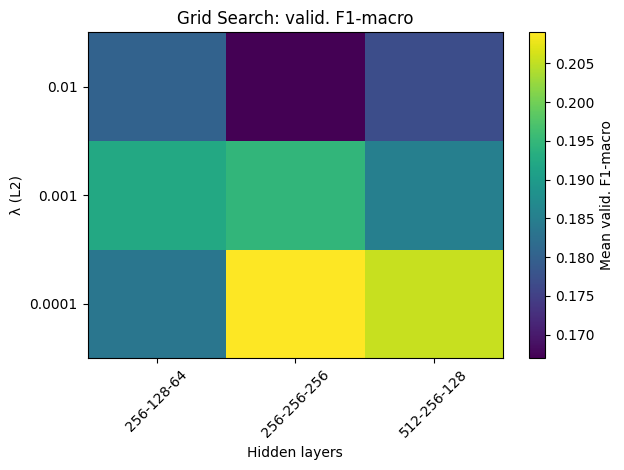

In [28]:
import numpy as np
import matplotlib.pyplot as plt

archs = sorted({k[0] for k in grid_results})
l2s   = sorted({k[1] for k in grid_results})
heat  = np.zeros((len(l2s), len(archs)))

for i, l2 in enumerate(l2s):
    for j, arch in enumerate(archs):
        heat[i, j] = grid_results[(arch, l2)]

plt.imshow(heat, origin='lower', aspect='auto')
plt.colorbar(label='Mean valid. F1-macro')
plt.xticks(np.arange(len(archs)), archs, rotation=45)
plt.yticks(np.arange(len(l2s)), l2s)
plt.xlabel('Hidden layers')
plt.ylabel('λ (L2)')
plt.title('Grid Search: valid. F1-macro')
plt.tight_layout()
plt.show()


## Random Forest

In [40]:
import pandas as pd

# Cargar el archivo de eventos válidos
eventos_df = pd.read_csv("eventos_validos.csv")

# Definir las posibles clases
tipos_evento = ["1 Stiker Slip (SS)", "2 Normal-Oblique", "3 Reverse-Oblique"]
magnitudes = ["Mag. 4-6", "Mag. 6-8"]
vs30_clases = ["Vs30. 0-200", "Vs30. 200-400", "Vs30. 400-600", "Vs30. 600-"]

# Crear un DataFrame vacío para los labels
labels = pd.DataFrame()

# Crear columnas para cada etiqueta
for tipo in tipos_evento:
    labels[tipo] = (eventos_df["Tipo de evento"] == tipo).astype(int)

for mag in magnitudes:
    labels[mag] = (eventos_df["Magnitud"] == mag).astype(int)

for vs in vs30_clases:
    labels[vs] = (eventos_df["Vs30"] == vs).astype(int)

# Guardar el archivo de labels
labels.to_csv("labels_eventos.csv", index=False)

print("✅ Archivo labels_eventos.csv creado correctamente.")


✅ Archivo labels_eventos.csv creado correctamente.


In [41]:
import pandas as pd

# Cargar features y labels
features = pd.read_csv('features_fft_eventos.csv')  # header=None si los datos no tienen nombre de columnas
labels = pd.read_csv('labels_eventos.csv')  # Aquí asumo que labels sí tiene encabezados (tipo_evento, magnitud, vs30, etc.)

# Verificar tamaños
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# Importante: verificar que el número de filas coincida
if features.shape[0] != labels.shape[0]:
    raise ValueError("El número de filas entre features y labels no coincide")

# Concatenar features y labels
dataset = pd.concat([features, labels], axis=1)

# Guardar dataset combinado
dataset.to_csv('dataset_completo.csv', index=False)

print("Dataset combinado guardado como 'dataset_completo.csv'")
print(dataset.columns)



Features shape: (1696, 771)
Labels shape: (1696, 9)
Dataset combinado guardado como 'dataset_completo.csv'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '770', '1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique',
       'Mag. 4-6', 'Mag. 6-8', 'Vs30. 0-200', 'Vs30. 200-400', 'Vs30. 400-600',
       'Vs30. 600-'],
      dtype='object', length=780)


In [43]:
import pandas as pd

# Cargar dataset
dataset = pd.read_csv('dataset_completo.csv')

# Definir columnas de etiquetas
label_columns = [
    '1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique',
    'Mag. 4-6', 'Mag. 6-8',
    'Vs30. 0-200', 'Vs30. 200-400', 'Vs30. 400-600', 'Vs30. 600-'
]

# Crear columna combinada
dataset['combined_labels'] = dataset[label_columns].apply(lambda x: '_'.join(map(str, x)), axis=1)

# Separar features y target combinado
X = dataset.drop(columns=label_columns + ['combined_labels'])
y = dataset['combined_labels']

# Contar combinaciones
conteo = y.value_counts()

# Mantener solo combinaciones que aparecen >=6 veces
combinaciones_validas = conteo[conteo >= 6].index

# Filtrar dataset
dataset_filtrado = dataset[dataset['combined_labels'].isin(combinaciones_validas)]

# 👉🏻 Desde aquí es donde cambiamos el flujo:

# --- NUEVO OVERSAMPLING MANUAL ---
objetivo_por_clase = 50  # Por ejemplo, queremos mínimo 50 ejemplos por clase

# Lista para los nuevos datos
nuevos_datos = []

# Agrupar y balancear
for combinacion in combinaciones_validas:
    datos_clase = dataset_filtrado[dataset_filtrado['combined_labels'] == combinacion]
    cantidad_actual = len(datos_clase)

    if cantidad_actual < objetivo_por_clase:
        # Calculamos cuántas veces repetir
        veces_repetir = objetivo_por_clase // cantidad_actual
        resto = objetivo_por_clase % cantidad_actual

        # Repetimos datos
        datos_repetidos = pd.concat([datos_clase] * veces_repetir, ignore_index=True)

        # Agregamos algunos extras si hace falta
        if resto > 0:
            datos_repetidos = pd.concat([datos_repetidos, datos_clase.sample(n=resto, replace=True)], ignore_index=True)

        nuevos_datos.append(datos_repetidos)
    else:
        nuevos_datos.append(datos_clase)

# Unir todo
dataset_balanceado = pd.concat(nuevos_datos, ignore_index=True)

# Volver a separar etiquetas
split_labels = dataset_balanceado['combined_labels'].str.split('_', expand=True).astype(int)
split_labels.columns = label_columns

# Eliminar columna combinada Y las etiquetas anteriores
dataset_balanceado = dataset_balanceado.drop(columns=label_columns + ['combined_labels']).join(split_labels)

# Guardar
dataset_balanceado.to_csv('dataset_balanceado_final.csv', index=False)

print("✅ Dataset balanceado correctamente y guardado como 'dataset_balanceado_final.csv'")


✅ Dataset balanceado correctamente y guardado como 'dataset_balanceado_final.csv'


In [47]:
import pandas as pd

# Si tienes un archivo CSV
df = pd.read_csv('dataset_balanceado_final.csv')

# Separar X (características)
X = df.iloc[:, 0:771]  # Columnas de la 0 a la 770

# Crear una nueva columna 'Clase' basada en cuál de las 3 está activa
def determinar_clase(fila):
    if fila['1 Stiker Slip (SS)'] == 1:
        return 'Sticker Slip'
    elif fila['2 Normal-Oblique'] == 1:
        return 'Strike Oblicuo'
    elif fila['3 Reverse-Oblique'] == 1:
        return 'Reverse Oblicuo'
    else:
        return 'Otro'

df['Clase'] = df.apply(determinar_clase, axis=1)

# Preparar X e y para RandomForest
X = df[[str(i) for i in range(0, 771)]]  # las columnas '0' a '770'
y = df['Clase']

# Verificar que cada fila tenga una sola etiqueta activa
multilabel_error = df[['1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique']].sum(axis=1) != 1

print(f"Número de filas con múltiples etiquetas activas: {multilabel_error.sum()}")

# Limpiar si es necesario
df = df[~multilabel_error]

# Crear columna de Clase
df['Clase'] = df.apply(determinar_clase, axis=1)

X = df[[str(i) for i in range(0, 771)]]
y = df['Clase']

print(df[['1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique']].sum())

Número de filas con múltiples etiquetas activas: 0
1 Stiker Slip (SS)    620
2 Normal-Oblique      501
3 Reverse-Oblique     707
dtype: int64


In [48]:
print(X.shape)
print(y.value_counts())
print(X.isnull().sum().sum())  # Verifica si hay valores NaN

(1828, 771)
Clase
Reverse Oblicuo    707
Sticker Slip       620
Strike Oblicuo     501
Name: count, dtype: int64
0


Accuracy: 0.60

Matriz de Confusión:
[[99 42 15]
 [28 80  3]
 [36 21 42]]

Reporte de Clasificación:
                 precision    recall  f1-score   support

Reverse Oblicuo       0.61      0.63      0.62       156
   Sticker Slip       0.56      0.72      0.63       111
 Strike Oblicuo       0.70      0.42      0.53        99

       accuracy                           0.60       366
      macro avg       0.62      0.59      0.59       366
   weighted avg       0.62      0.60      0.60       366

Features: 10 - Accuracy: 0.6038
Features: 20 - Accuracy: 0.6148
Features: 30 - Accuracy: 0.6175
Features: 40 - Accuracy: 0.6230
Features: 50 - Accuracy: 0.5902
Features: 70 - Accuracy: 0.6066
Features: 100 - Accuracy: 0.6202


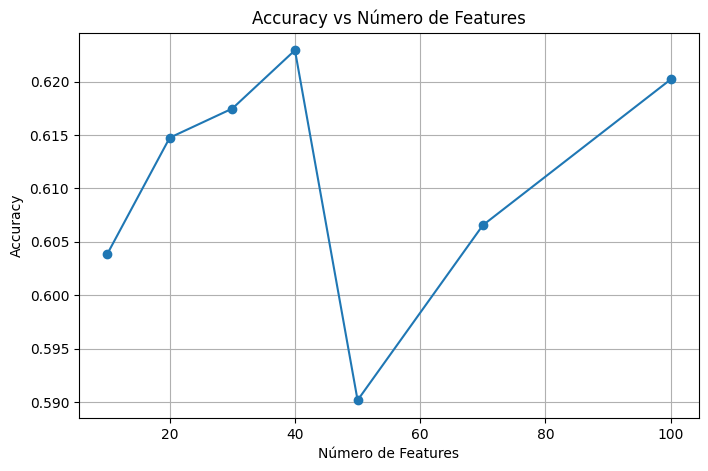

Random Forest F1_micro: 0.5613 (+/- 0.0193)


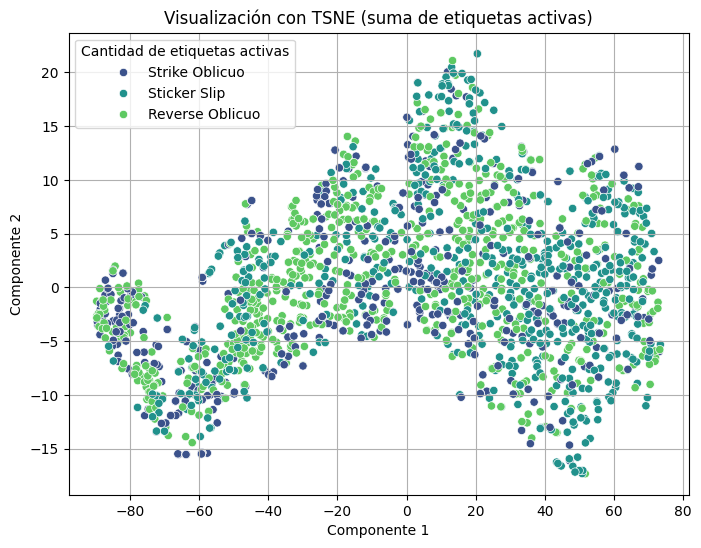

Mejores parámetros encontrados para Random Forest: {'clf__estimator__max_depth': 10, 'clf__estimator__max_features': 0.5, 'clf__estimator__min_samples_leaf': 5, 'clf__estimator__n_estimators': 100}


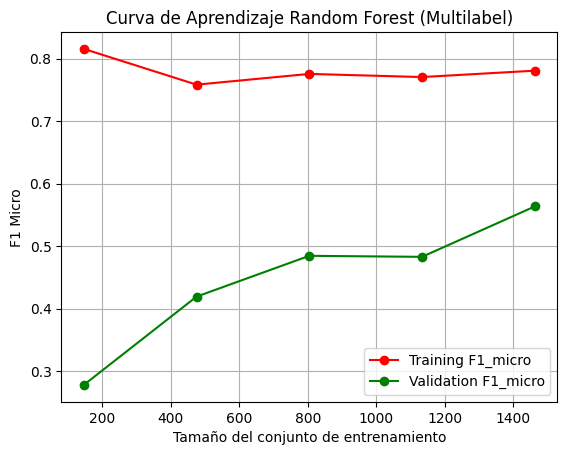

In [49]:
## Proyecto: Random Forest desde features procesados

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.manifold import TSNE

from scipy.stats import ttest_rel

# ------------------------------------
# 1. Cargar datos procesados (features)
# ------------------------------------

X = pd.read_csv('features_top100.csv')
# Asegurarse que Y esté correctamente cargado
# y = ... (aquí deberías cargar tus etiquetas)

# ------------------------------------
# 2. Random Forest Simple
# ------------------------------------

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Random Forest
modelo = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
modelo.fit(X_train, y_train)

# Predicción
y_pred = modelo.predict(X_test)

# Evaluación
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# ------------------------------------
# 3. Evaluar accuracy con diferentes número de features
# ------------------------------------

importancias = modelo.feature_importances_
indices_importantes = np.argsort(importancias)[::-1]

valores_k = [10, 20, 30, 40, 50, 70, 100]
accuracies = []

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for k in valores_k:
    selected_features = indices_importantes[:k]
    X_train = X_train_full.iloc[:, selected_features]
    X_test = X_test_full.iloc[:, selected_features]
    
    modelo_k = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
    modelo_k.fit(X_train, y_train)
    y_pred = modelo_k.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Resultados
for k, acc in zip(valores_k, accuracies):
    print(f"Features: {k} - Accuracy: {acc:.4f}")

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(valores_k, accuracies, marker='o')
plt.title('Accuracy vs Número de Features')
plt.xlabel('Número de Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# ------------------------------------
# 4. Random Forest Multietiqueta con Pipeline
# ------------------------------------

pipeline_rf = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=70)),
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=15,
        max_features='sqrt',
        random_state=42
    )))
])

# Cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

scores_rf = cross_val_score(pipeline_rf, X, y, cv=rkf, scoring='f1_micro')
print(f'Random Forest F1_micro: {scores_rf.mean():.4f} (+/- {scores_rf.std():.4f})')

# ------------------------------------
# 5. Visualización t-SNE
# ------------------------------------

X_reduced = SelectKBest(score_func=f_classif, k=50).fit_transform(X, y)
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis')
plt.title('Visualización con TSNE (suma de etiquetas activas)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Cantidad de etiquetas activas')
plt.grid(True)
plt.show()

# ------------------------------------
# 6. Optimización de hiperparámetros
# ------------------------------------

param_grid = {
    'clf__estimator__n_estimators': [100],
    'clf__estimator__max_depth': [5, 8, 10],
    'clf__estimator__min_samples_leaf': [5, 10, 15, 20],
    'clf__estimator__max_features': ['sqrt', 0.5, 0.7]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid, cv=rkf, scoring='f1_micro')
grid_search_rf.fit(X, y)

print(f"Mejores parámetros encontrados para Random Forest: {grid_search_rf.best_params_}")

# ------------------------------------
# 7. Curva de aprendizaje
# ------------------------------------

train_sizes, train_scores, test_scores = learning_curve(
    pipeline_rf, X, y, cv=rkf, n_jobs=-1, scoring='f1_micro', 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1_micro")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation F1_micro")
plt.title('Curva de Aprendizaje Random Forest (Multilabel)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('F1 Micro')
plt.legend(loc="best")
plt.grid()
plt.show()


## SVM

Fitting 15 folds for each of 120 candidates, totalling 1800 fits
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; total time=   0.8s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; total time=   0.8s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; total time=   0.8s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=scale; to

/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.8s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.8s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.9s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.8s
[CV] END clf__estimator__select__k=8, clf__estimator__svc__C=0.1, clf__estimator__svc__gamma=0.01; total time=   0.7s
[CV] END clf__estimator__select__k=8, clf__estimator__sv

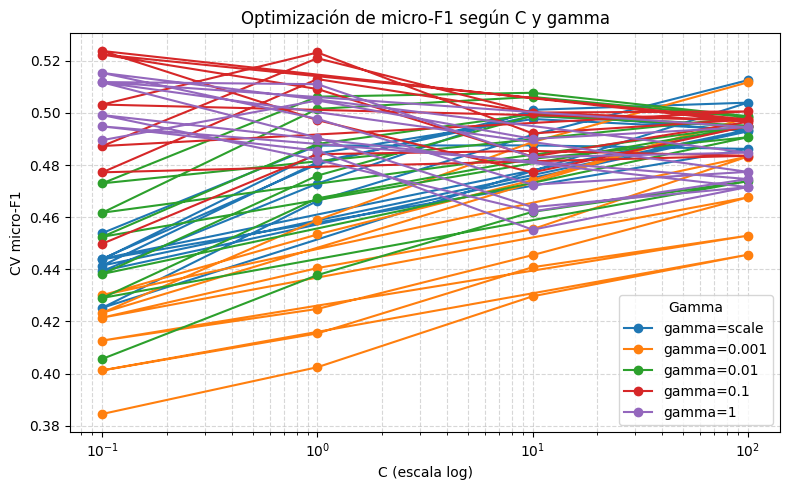

/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


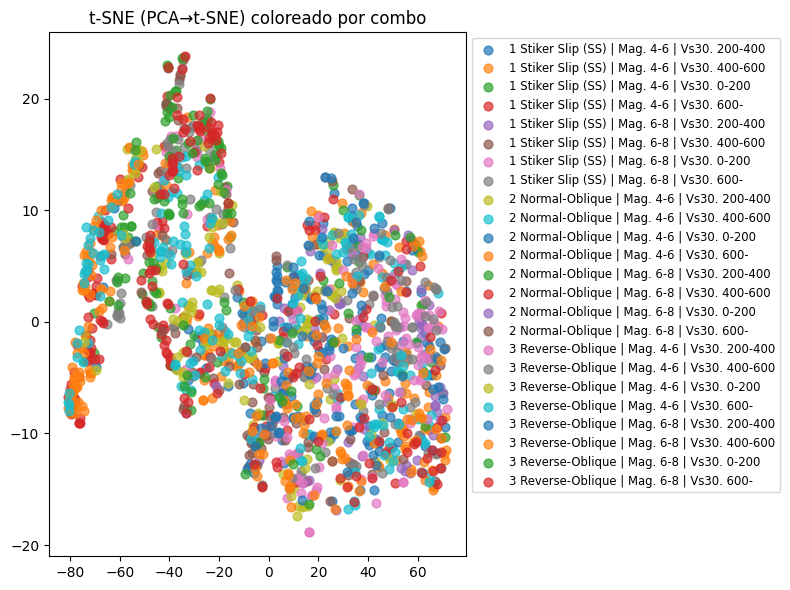


--- Classification Report on TEST ---
              precision    recall  f1-score   support

           0       0.37      0.81      0.51       120
           1       0.25      0.48      0.33        81
           2       0.44      0.62      0.51       139
           3       0.59      0.93      0.72       188
           4       0.68      0.20      0.31       152
           5       0.21      0.69      0.32        42
           6       0.43      0.92      0.58        90
           7       0.38      0.66      0.49       116
           8       0.47      0.71      0.57        92

   micro avg       0.42      0.67      0.51      1020
   macro avg       0.42      0.67      0.48      1020
weighted avg       0.47      0.67      0.50      1020
 samples avg       0.42      0.67      0.51      1020


micro-F1 en TEST:      0.5138
Jaccard (samples) en TEST: 0.3708


'\nCon este flujo obtuvimos:\n\nF1 (samples) en CV: 0.5261\nF1 (samples) en validación: 0.5028\nTest (tras aplicar umbrales óptimos):\nmicro-F1≈0.50, micro-recall≈0.57, micro-precision≈0.45\nLa clase más frecuente (etiqueta 3) alcanza F1≈0.75, mientras que algunas de soporte menor (p. ej. clases 2 y 4) quedan alrededor de F1≈0.32–0.46.\n'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection       import SelectKBest, f_classif
from sklearn.preprocessing          import StandardScaler, OneHotEncoder
from sklearn.svm                    import SVC
from sklearn.multioutput            import MultiOutputClassifier
from sklearn.model_selection        import (
    train_test_split,
    GridSearchCV,
    RepeatedKFold,
    learning_curve
)
from sklearn.pipeline               import Pipeline
from sklearn.manifold               import TSNE
from sklearn.metrics                import (
    classification_report,
    f1_score,
    jaccard_score,
    make_scorer
)

# ——————————————
# carga de datos y split
# ——————————————
X = pd.read_csv('features_fft_eventos.csv')
labels = pd.read_csv('eventos_validos.csv')
labels['combo'] = (
    labels['Tipo de evento'].astype(str) + ' | ' +
    labels['Magnitud'].astype(str)     + ' | ' +
    labels['Vs30'].astype(str)
)

ohe = OneHotEncoder(sparse_output=False)
Y = ohe.fit_transform(labels[['Tipo de evento','Magnitud','Vs30']])

X_temp, X_test, Y_temp, Y_test, _, _ = train_test_split(
    X, Y, labels['combo'],
    test_size=0.20,
    random_state=42,
    stratify=labels['Tipo de evento']
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp,
    test_size=0.25,
    random_state=42,
    stratify=np.argmax(Y_temp, axis=1)
)

# ——————————————
# Pipeline: SelectKBest + SVC dentro de MultiOutputClassifier
# ——————————————
base_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=100)),
    ('svc',    SVC(kernel='rbf', probability=True, class_weight='balanced'))
])

pipeline = Pipeline([
    ('clf', MultiOutputClassifier(base_estimator, n_jobs=-1))
])

# ——————————————
# GridSearchCV 
# ——————————————
param_grid = {
    'clf__estimator__select__k':   [8, 39, 77, 154, 385, 771], # 1% 5% 10% 20% 50% 100%
    'clf__estimator__svc__C':      [0.1, 1, 10, 100],
    'clf__estimator__svc__gamma':  ['scale', 0.001, 0.01, 0.1, 1]
}

# dos metricas apropiadas para multilabel
scoring = {
    'F1_micro':         make_scorer(f1_score,      average='micro'),
    'Jaccard_samples':  make_scorer(jaccard_score, average='samples')
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='F1_micro',   # refit con f1 al mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, Y_train)

# resultados CV
best_i = grid.best_index_
print(f"Mejor micro-F1 en CV:       {grid.cv_results_['mean_test_F1_micro'][best_i]:.4f}")
print(f"Mejor Jaccard (samples) en CV: {grid.cv_results_['mean_test_Jaccard_samples'][best_i]:.4f}")
print(f"Mejores parámetros (por micro-F1): {grid.best_params_}")

# ——————————————
# validacion en validation set
# ——————————————
best_model = grid.best_estimator_
Y_val_pred = best_model.predict(X_val)

val_f1_micro  = f1_score(Y_val, Y_val_pred, average='micro')
val_jaccard   = jaccard_score(Y_val, Y_val_pred, average='samples')

print(f"micro-F1 en validation set:       {val_f1_micro:.4f}")
print(f"Jaccard (samples) en validation set: {val_jaccard:.4f}")

# ——————————————
# graficar gamma vs C
# ——————————————
# convertimos cv_results_ a DataFrame
results = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8, 5))
for gamma in sorted(results['param_clf__estimator__svc__gamma'].unique(), 
                    key=lambda x: (str(x)!='scale', float(x) if x!='scale' else -1)):
    mask = results['param_clf__estimator__svc__gamma'] == gamma
    Cs   = results.loc[mask, 'param_clf__estimator__svc__C'].astype(float)
    f1s  = results.loc[mask, 'mean_test_F1_micro']  # explicito micro-F1
    plt.semilogx(Cs, f1s, marker='o', label=f'gamma={gamma}')

plt.xlabel('C (escala log)')
plt.ylabel('CV micro-F1')
plt.title('Optimización de micro-F1 según C y gamma')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title='Gamma')
plt.tight_layout()
plt.show()


# ——————————————
# curva de aprendizaje (F1 samples)
# ——————————————
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,                
    X=X_train,
    y=Y_train,
    cv=cv,
    scoring=make_scorer(f1_score, average='samples'),
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42,
    n_jobs=-1
)
# calcular medias de puntuación
train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores,   axis=1)

# convertimos proporciones a numero absoluto de muestras
train_sizes_abs = (train_sizes * len(X_train)).astype(int)



# ——————————————
# t-SNE completo (coloreado por combo)
# ——————————————
from sklearn.decomposition import PCA

# 1) Reducimos a 50 dimensiones con PCA
X_scaled = StandardScaler().fit_transform(X)
X_pca    = PCA(n_components=50).fit_transform(X_scaled)

# 2) t-SNE sobre ese espacio reducido
emb = TSNE(
    n_components=2,
    perplexity=30,
    init='pca',
    learning_rate='auto',
    random_state=42
).fit_transform(X_pca)

plt.figure(figsize=(8, 6))
for lbl in labels['combo'].unique():
    idx = labels['combo'] == lbl
    plt.scatter(
        emb[idx, 0], emb[idx, 1],
        s=40, alpha=0.7,
        label=lbl
    )
plt.legend(bbox_to_anchor=(1,1), fontsize='small')
plt.title('t-SNE (PCA→t-SNE) coloreado por combo')
plt.tight_layout()
plt.show()


# ——————————————
# Evaluacion final en TEST
# ——————————————
Y_test_pred = best_model.predict(X_test)

# Reporte clasico
print("\n--- Classification Report on TEST ---")
print(classification_report(Y_test, Y_test_pred, zero_division=0))

# Metricas globales
test_f1_micro  = f1_score(Y_test, Y_test_pred, average='micro')
test_jaccard   = jaccard_score(Y_test, Y_test_pred, average='samples')
print(f"\nmicro-F1 en TEST:      {test_f1_micro:.4f}")
print(f"Jaccard (samples) en TEST: {test_jaccard:.4f}")

'''
Con este flujo obtuvimos:

F1 (samples) en CV: 0.5261
F1 (samples) en validación: 0.5028
Test (tras aplicar umbrales óptimos):
micro-F1≈0.50, micro-recall≈0.57, micro-precision≈0.45
La clase más frecuente (etiqueta 3) alcanza F1≈0.75, mientras que algunas de soporte menor (p. ej. clases 2 y 4) quedan alrededor de F1≈0.32–0.46.
'''


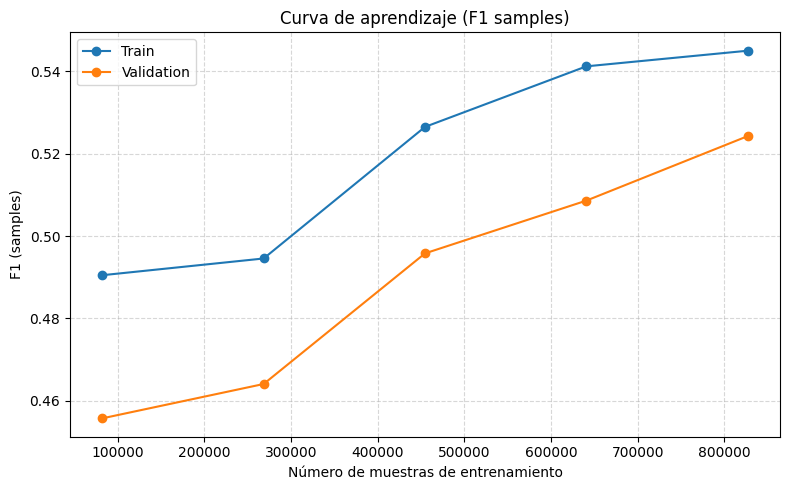

In [50]:
# ——————————————
# plot de la curva de aprendizaje de SVM
# ——————————————
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_abs, train_mean, marker='o', label='Train')
plt.plot(train_sizes_abs, val_mean,   marker='o', label='Validation')
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('F1 (samples)')
plt.title('Curva de aprendizaje (F1 samples)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()